# Image Recognition for Learning Arabic Words

## 1. Introduction

Arabic is a complex and interesting language. It is one of the official languages of the United Nations, and is spoken by about 350 million native speakers.

In this notebook, the [Massively Multilingual Image Dataset (MMID)](https://multilingual-images.org/) will be used to train several pre-trained models. As the dataset consist of images, where the exact position of an object of interest is not of a particular relevance, convolutional neural networks (CNN) will be used.

## 2. Data pre-processing

### 2.1 Downloading of data

Prior to starting the project, the dataset will need to be downloaded from Amazon Web Services (AWS) Simple Storage Service (S3).

In [201]:
# browse the S3 bucket
! aws s3 ls --no-sign-request s3://mmid-pds/

/bin/bash: /home/ubuntu/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
                           PRE language_image_packages/
                           PRE language_index_files/
                           PRE language_metadata_files/
                           PRE language_text_warcs/
                           PRE mini_language_image_packages/


In [203]:
# list the directory content and check the file size
! aws s3 ls --no-sign-request s3://mmid-pds/language_image_packages/ --human-readable

/bin/bash: /home/ubuntu/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2019-02-14 06:50:09   19.0 GiB scale-afrikaans-package.tgz
2019-01-23 08:38:51   16.3 GiB scale-albanian-package.tgz
2019-02-14 06:50:09   11.4 GiB scale-amharic-package.tgz
2019-01-23 08:38:52   16.6 GiB scale-arabic-package.tgz
2019-01-23 08:38:52    5.8 GiB scale-aragonese-package.tgz
2019-01-23 08:38:52    3.3 GiB scale-armenian-package.tgz
2019-01-23 08:40:41    6.4 GiB scale-asturian-package.tgz
2019-01-23 08:42:00   17.3 GiB scale-azerbaijani-package.tgz
2019-01-23 08:44:15   18.8 GiB scale-basque-package.tgz
2019-01-23 08:47:51   20.6 GiB scale-belarusian-package.tgz
2019-01-23 08:47:59   16.5 GiB scale-bengali-package.tgz
2019-01-23 08:49:20   10.4 GiB scale-bishnupriya-manipuri-package.tgz
2019-01-23 08:51:47   18.3 GiB scale-bosnian-package.tgz
2019-02-14 06:50:09   12.2 GiB scale-breton-package.tgz
2019-01-23 08:55:19   20.8 GiB scale-bulgarian-package.tgz
2019-01-

In [ ]:
# download the arabic tar-zipped file to the local disk
! aws s3 cp --no-sign-request s3://mmid-pds/language_image_packages/scale-arabic-package.tgz .

### 2.2 Data organization

TensorFlow image loading allows for the creation of a generator object, instead of loading the entire dataset into RAM in one go. Instead, only enough number of images are read into RAM and provided into Tensorflow for training. While this batch is training, the second batch of images are loaded and can be transferred into GPU as needed.

This step is especially important since most GPUs, such as [NVIDIA T4](https://www.nvidia.com/en-us/data-center/tesla-t4/) and [Tesla V100](https://www.nvidia.com/en-us/data-center/v100/), have a memory of 16 GiB. The entire dataset for MMID is already larger than 16 GiB after extraction from the `.tgz` file. Reading datasets into memory from disk in one whole batch is also slow, and this problem can become slower if the datasets are located on a distributed file system. Although the use of high-end GPUs, such as the [NVIDIA A100 NVIDIA with 80 GiB GPU memory](https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-nvidia-us-2188504-web.pdf) can overcome this limitation, it is extremely expensive and might not be available to all researchers.

By using commodity hardware, including those with previous/low-end GPUs, this image loading/generator technique becomes suitable for CNN.


#### 2.2.1 Renaming of folders 

The TensorFlow image generator provides two main functions:

- create a generator object that loads images in batches so as not to overload the GPU memory, and
- provide labels for model training

The original form of MMID consists of folders labelled as numbers (1,2,...) and a text file `word.txt` that contains the actual word used in image collection through Google Image Search. However, these numeric labels are of no use to TensorFlow generator. Instead, by renaming the folders into their corresponding Arabic words, the generator can automatically create labels for training. This renaming process will also streamline report writing later on, as each folder can be easily tracked and explored.

In [1]:
# for each folder, rename to the word given in word.txt (Arabic label)

import os

def rename_folders(path):
    """
    define a function that takes in a path as an input
    and then rename the folders accordingly
    """
    
    # iterate through each folder
    for i in os.listdir(folder_path):
        # ignore the tab-separated label file
        if i.endswith('tsv'):
            continue

        # create paths from folder names and the actual word
        # as given by the individual 'word.txt' file
        full_path = f'{folder_path}/{i}/'
        with open(full_path + 'word.txt') as f:
            file_name = f.read()

        # essentially, do a string concatenation
        # and rename the folders
        file_name = f'{folder_path}/{file_name}/'
        os.rename(full_path, file_name)
        print(i, file_name)

In [3]:
# rename the full data package
folder_path = '../full_data/scale-arabic-package'
rename_folders(folder_path)

1827 ../full_data/scale-arabic-package/الجيدة/
8650 ../full_data/scale-arabic-package/والأدب/
5689 ../full_data/scale-arabic-package/خمسة/
6455 ../full_data/scale-arabic-package/طريقها/
7817 ../full_data/scale-arabic-package/مجرى/
2093 ../full_data/scale-arabic-package/الدقيق/
6101 ../full_data/scale-arabic-package/سلالة/
5938 ../full_data/scale-arabic-package/روح/
4571 ../full_data/scale-arabic-package/بلاط/
1398 ../full_data/scale-arabic-package/البصريات/
8135 ../full_data/scale-arabic-package/مكتوبة/
4366 ../full_data/scale-arabic-package/بجامعة/
8286 ../full_data/scale-arabic-package/ميل/
3294 ../full_data/scale-arabic-package/اللهجة/
7640 ../full_data/scale-arabic-package/لمعالجة/
3221 ../full_data/scale-arabic-package/الكلاسيكي/
3883 ../full_data/scale-arabic-package/الناجمة/
3203 ../full_data/scale-arabic-package/الكثيرة/
3670 ../full_data/scale-arabic-package/المعسكر/
4390 ../full_data/scale-arabic-package/بحيرة/
8229 ../full_data/scale-arabic-package/مهمًا/
7848 ../full_data/s

4540 ../full_data/scale-arabic-package/بقاء/
4855 ../full_data/scale-arabic-package/تدريجيا/
943 ../full_data/scale-arabic-package/الأضلاع/
9537 ../full_data/scale-arabic-package/يحصل/
1569 ../full_data/scale-arabic-package/التصوف/
1616 ../full_data/scale-arabic-package/التقليدية/
2823 ../full_data/scale-arabic-package/العلوية/
8720 ../full_data/scale-arabic-package/والحركة/
1164 ../full_data/scale-arabic-package/الإغريقي/
7781 ../full_data/scale-arabic-package/متزوج/
3551 ../full_data/scale-arabic-package/المستمر/
8610 ../full_data/scale-arabic-package/وإيطاليا/
729 ../full_data/scale-arabic-package/اشتهرت/
4446 ../full_data/scale-arabic-package/بروسيا/
4465 ../full_data/scale-arabic-package/بسيطة/
8147 ../full_data/scale-arabic-package/ملحوظ/
5067 ../full_data/scale-arabic-package/تفقد/
2413 ../full_data/scale-arabic-package/السودانية/
6017 ../full_data/scale-arabic-package/ساراكينوس/
7202 ../full_data/scale-arabic-package/كتل/
8243 ../full_data/scale-arabic-package/موت/
2867 ../full

4236 ../full_data/scale-arabic-package/بإرسال/
7786 ../full_data/scale-arabic-package/متعدد/
252 ../full_data/scale-arabic-package/أعداد/
8647 ../full_data/scale-arabic-package/والأحزاب/
6193 ../full_data/scale-arabic-package/سيناء/
3289 ../full_data/scale-arabic-package/اللفظ/
2659 ../full_data/scale-arabic-package/الطبيب/
4442 ../full_data/scale-arabic-package/بروبيلين/
7978 ../full_data/scale-arabic-package/مسيرة/
9726 ../full_data/scale-arabic-package/يكونوا/
5678 ../full_data/scale-arabic-package/خلفها/
6507 ../full_data/scale-arabic-package/عادوا/
3586 ../full_data/scale-arabic-package/المشروبات/
1423 ../full_data/scale-arabic-package/البلاغة/
2274 ../full_data/scale-arabic-package/الزكاة/
3336 ../full_data/scale-arabic-package/المادية/
2446 ../full_data/scale-arabic-package/السير/
9491 ../full_data/scale-arabic-package/يتصل/
4397 ../full_data/scale-arabic-package/بدءا/
2374 ../full_data/scale-arabic-package/السلسلة/
787 ../full_data/scale-arabic-package/الآسيوي/
9268 ../full_dat

2163 ../full_data/scale-arabic-package/الرئة/
320 ../full_data/scale-arabic-package/أكمل/
8258 ../full_data/scale-arabic-package/موسيقية/
2905 ../full_data/scale-arabic-package/الفاتيكان/
8856 ../full_data/scale-arabic-package/والمملكة/
9489 ../full_data/scale-arabic-package/يترك/
42 ../full_data/scale-arabic-package/أبداً/
2604 ../full_data/scale-arabic-package/الصناعي/
5631 ../full_data/scale-arabic-package/خديجة/
6244 ../full_data/scale-arabic-package/شرف/
8639 ../full_data/scale-arabic-package/وافق/
979 ../full_data/scale-arabic-package/الأفلام/
5620 ../full_data/scale-arabic-package/خاصية/
6595 ../full_data/scale-arabic-package/عشرات/
4841 ../full_data/scale-arabic-package/تحيط/
6640 ../full_data/scale-arabic-package/علماء/
3868 ../full_data/scale-arabic-package/الميثان/
7527 ../full_data/scale-arabic-package/للحفاظ/
1089 ../full_data/scale-arabic-package/الأوسط/
2235 ../full_data/scale-arabic-package/الرها/
1431 ../full_data/scale-arabic-package/البلغارية/
2726 ../full_data/scale

5493 ../full_data/scale-arabic-package/حروف/
7245 ../full_data/scale-arabic-package/كليات/
3567 ../full_data/scale-arabic-package/المسلمين/
2262 ../full_data/scale-arabic-package/الريف/
9643 ../full_data/scale-arabic-package/يضاف/
1065 ../full_data/scale-arabic-package/الأنماط/
8973 ../full_data/scale-arabic-package/وتطورت/
5340 ../full_data/scale-arabic-package/جعل/
6855 ../full_data/scale-arabic-package/فرقة/
6654 ../full_data/scale-arabic-package/عليهما/
1477 ../full_data/scale-arabic-package/التأكيد/
874 ../full_data/scale-arabic-package/الأردن/
7505 ../full_data/scale-arabic-package/للتدخين/
3331 ../full_data/scale-arabic-package/المائدة/
1667 ../full_data/scale-arabic-package/التوقيع/
6999 ../full_data/scale-arabic-package/قاسم/
4790 ../full_data/scale-arabic-package/تجارب/
636 ../full_data/scale-arabic-package/اثنتين/
8131 ../full_data/scale-arabic-package/مكة/
6580 ../full_data/scale-arabic-package/عرفات/
7462 ../full_data/scale-arabic-package/لقوات/
3373 ../full_data/scale-ara

8876 ../full_data/scale-arabic-package/والهند/
9471 ../full_data/scale-arabic-package/يبعد/
6032 ../full_data/scale-arabic-package/سباق/
7722 ../full_data/scale-arabic-package/ما/
113 ../full_data/scale-arabic-package/أخذ/
8414 ../full_data/scale-arabic-package/نمت/
220 ../full_data/scale-arabic-package/أصبح/
6829 ../full_data/scale-arabic-package/فجاء/
6022 ../full_data/scale-arabic-package/ساعدت/
7271 ../full_data/scale-arabic-package/كوريا/
1532 ../full_data/scale-arabic-package/التربية/
7962 ../full_data/scale-arabic-package/مستويات/
1710 ../full_data/scale-arabic-package/الثنائي/
3951 ../full_data/scale-arabic-package/النظامي/
7773 ../full_data/scale-arabic-package/متحركة/
9657 ../full_data/scale-arabic-package/يعتبرون/
404 ../full_data/scale-arabic-package/أنهما/
4069 ../full_data/scale-arabic-package/الوجه/
7176 ../full_data/scale-arabic-package/كان/
3017 ../full_data/scale-arabic-package/الفيدرالي/
6630 ../full_data/scale-arabic-package/علاج/
4975 ../full_data/scale-arabic-pack

4515 ../full_data/scale-arabic-package/بعقد/
9711 ../full_data/scale-arabic-package/يقل/
9507 ../full_data/scale-arabic-package/يتناول/
6154 ../full_data/scale-arabic-package/سوري/
8985 ../full_data/scale-arabic-package/وتعيين/
3768 ../full_data/scale-arabic-package/المملوكي/
1296 ../full_data/scale-arabic-package/الامير/
8618 ../full_data/scale-arabic-package/واحد/
8051 ../full_data/scale-arabic-package/معتدل/
2781 ../full_data/scale-arabic-package/العصبية/
5950 ../full_data/scale-arabic-package/رياض/
8040 ../full_data/scale-arabic-package/معارك/
4973 ../full_data/scale-arabic-package/تصنيف/
5605 ../full_data/scale-arabic-package/حين/
9236 ../full_data/scale-arabic-package/وقبل/
8950 ../full_data/scale-arabic-package/وتحتوي/
6358 ../full_data/scale-arabic-package/صفحات/
125 ../full_data/scale-arabic-package/أداء/
6243 ../full_data/scale-arabic-package/شرعية/
2362 ../full_data/scale-arabic-package/السكن/
4850 ../full_data/scale-arabic-package/تخفيض/
7099 ../full_data/scale-arabic-packa

9517 ../full_data/scale-arabic-package/يجد/
504 ../full_data/scale-arabic-package/إدخال/
9710 ../full_data/scale-arabic-package/يقف/
681 ../full_data/scale-arabic-package/ازدياد/
5877 ../full_data/scale-arabic-package/رجال/
7109 ../full_data/scale-arabic-package/قليلاً/
6618 ../full_data/scale-arabic-package/عقارب/
4142 ../full_data/scale-arabic-package/اليومية/
765 ../full_data/scale-arabic-package/اقتصادية/
8862 ../full_data/scale-arabic-package/والمواد/
5697 ../full_data/scale-arabic-package/خير/
1362 ../full_data/scale-arabic-package/البراكين/
4777 ../full_data/scale-arabic-package/تتم/
8786 ../full_data/scale-arabic-package/والعديد/
478 ../full_data/scale-arabic-package/أيوب/
2595 ../full_data/scale-arabic-package/الصلح/
1111 ../full_data/scale-arabic-package/الإبراهيمية/
2376 ../full_data/scale-arabic-package/السلطان/
3789 ../full_data/scale-arabic-package/المنتدى/
96 ../full_data/scale-arabic-package/أحزاب/
2280 ../full_data/scale-arabic-package/الزمني/
5487 ../full_data/scale-a

6177 ../full_data/scale-arabic-package/سيد/
1688 ../full_data/scale-arabic-package/الثروة/
7974 ../full_data/scale-arabic-package/مسلمين/
1846 ../full_data/scale-arabic-package/الحاصل/
2029 ../full_data/scale-arabic-package/الخلفاء/
4471 ../full_data/scale-arabic-package/بشرط/
7497 ../full_data/scale-arabic-package/للاقتصاد/
7946 ../full_data/scale-arabic-package/مسافة/
4600 ../full_data/scale-arabic-package/بمكة/
5038 ../full_data/scale-arabic-package/تعرف/
9289 ../full_data/scale-arabic-package/ولد/
7392 ../full_data/scale-arabic-package/لحوالي/
7562 ../full_data/scale-arabic-package/للعالم/
3377 ../full_data/scale-arabic-package/المتقدمة/
2746 ../full_data/scale-arabic-package/العدوان/
3627 ../full_data/scale-arabic-package/المطلوب/
2655 ../full_data/scale-arabic-package/الطبري/
7899 ../full_data/scale-arabic-package/مراكز/
4771 ../full_data/scale-arabic-package/تتعامل/
2313 ../full_data/scale-arabic-package/السادس/
3932 ../full_data/scale-arabic-package/النسخ/
4697 ../full_data/sca

1254 ../full_data/scale-arabic-package/الاستسلام/
2031 ../full_data/scale-arabic-package/الخلق/
9159 ../full_data/scale-arabic-package/وطريق/
3717 ../full_data/scale-arabic-package/المقدس/
9325 ../full_data/scale-arabic-package/ومجموعة/
3946 ../full_data/scale-arabic-package/النصوص/
1350 ../full_data/scale-arabic-package/البخار/
8845 ../full_data/scale-arabic-package/والمسيحيين/
9518 ../full_data/scale-arabic-package/يجري/
8450 ../full_data/scale-arabic-package/هائل/
3681 ../full_data/scale-arabic-package/المغاربة/
1932 ../full_data/scale-arabic-package/الحقول/
6970 ../full_data/scale-arabic-package/فيليب/
4576 ../full_data/scale-arabic-package/بلدة/
6514 ../full_data/scale-arabic-package/عاشوراء/
4633 ../full_data/scale-arabic-package/بنيت/
3515 ../full_data/scale-arabic-package/المزارعين/
1177 ../full_data/scale-arabic-package/الإلهي/
2693 ../full_data/scale-arabic-package/الظلام/
5457 ../full_data/scale-arabic-package/حجة/
3894 ../full_data/scale-arabic-package/الناطقة/
744 ../full_

3707 ../full_data/scale-arabic-package/المقارنة/
1657 ../full_data/scale-arabic-package/التوازن/
3590 ../full_data/scale-arabic-package/المشكلات/
275 ../full_data/scale-arabic-package/أغلبية/
413 ../full_data/scale-arabic-package/أهالي/
8471 ../full_data/scale-arabic-package/هدف/
4793 ../full_data/scale-arabic-package/تجارية/
949 ../full_data/scale-arabic-package/الأطفال/
9602 ../full_data/scale-arabic-package/يستخدم/
4785 ../full_data/scale-arabic-package/تتوفر/
3344 ../full_data/scale-arabic-package/المالكي/
8133 ../full_data/scale-arabic-package/مكتبة/
5564 ../full_data/scale-arabic-package/حماد/
2584 ../full_data/scale-arabic-package/الصفا/
8972 ../full_data/scale-arabic-package/وتطور/
3783 ../full_data/scale-arabic-package/المناهضة/
1676 ../full_data/scale-arabic-package/الثالثة/
7158 ../full_data/scale-arabic-package/كاجو/
7813 ../full_data/scale-arabic-package/مجتمعات/
8564 ../full_data/scale-arabic-package/وأغلب/
3633 ../full_data/scale-arabic-package/المعادن/
3392 ../full_data

7750 ../full_data/scale-arabic-package/مايكروسوفت/
8566 ../full_data/scale-arabic-package/وأفغانستان/
7087 ../full_data/scale-arabic-package/قضيبه/
8499 ../full_data/scale-arabic-package/هنا/
9255 ../full_data/scale-arabic-package/وقيل/
8733 ../full_data/scale-arabic-package/والخارجية/
6059 ../full_data/scale-arabic-package/سرطان/
206 ../full_data/scale-arabic-package/أسود/
947 ../full_data/scale-arabic-package/الأطرش/
8619 ../full_data/scale-arabic-package/واحدا/
5003 ../full_data/scale-arabic-package/تضخم/
7547 ../full_data/scale-arabic-package/للسلام/
6895 ../full_data/scale-arabic-package/فقدت/
2273 ../full_data/scale-arabic-package/الزعيم/
8208 ../full_data/scale-arabic-package/منظمات/
8073 ../full_data/scale-arabic-package/معمر/
1147 ../full_data/scale-arabic-package/الإسماعيلية/
2560 ../full_data/scale-arabic-package/الصحفيين/
586 ../full_data/scale-arabic-package/إنفلونزا/
1218 ../full_data/scale-arabic-package/الاتحاد/
4216 ../full_data/scale-arabic-package/ب/
9308 ../full_dat

5064 ../full_data/scale-arabic-package/تفسير/
5583 ../full_data/scale-arabic-package/حنك/
444 ../full_data/scale-arabic-package/أوصى/
1528 ../full_data/scale-arabic-package/التراب/
5311 ../full_data/scale-arabic-package/جديدة/
3142 ../full_data/scale-arabic-package/القماش/
2725 ../full_data/scale-arabic-package/العبادة/
2678 ../full_data/scale-arabic-package/الطلبة/
6170 ../full_data/scale-arabic-package/سياسة/
3629 ../full_data/scale-arabic-package/المطيرة/
9224 ../full_data/scale-arabic-package/وفي/
6258 ../full_data/scale-arabic-package/شعار/
7784 ../full_data/scale-arabic-package/متطلبات/
5242 ../full_data/scale-arabic-package/ثالث/
4762 ../full_data/scale-arabic-package/تتسبب/
1607 ../full_data/scale-arabic-package/التقارير/
3607 ../full_data/scale-arabic-package/المصري/
9436 ../full_data/scale-arabic-package/ويقدم/
639 ../full_data/scale-arabic-package/اجتماعات/
2091 ../full_data/scale-arabic-package/الدفاعية/
7023 ../full_data/scale-arabic-package/قبل/
2444 ../full_data/scale-ar

1074 ../full_data/scale-arabic-package/الأهم/
2137 ../full_data/scale-arabic-package/الذات/
6161 ../full_data/scale-arabic-package/سويسرا/
1310 ../full_data/scale-arabic-package/الاندماج/
1166 ../full_data/scale-arabic-package/الإفريقي/
7706 ../full_data/scale-arabic-package/مؤتمر/
246 ../full_data/scale-arabic-package/أطول/
2754 ../full_data/scale-arabic-package/العراقيين/
9259 ../full_data/scale-arabic-package/وكان/
5604 ../full_data/scale-arabic-package/حيفا/
8839 ../full_data/scale-arabic-package/والمدارس/
2508 ../full_data/scale-arabic-package/الشعراوي/
8976 ../full_data/scale-arabic-package/وتعالى/
58 ../full_data/scale-arabic-package/أبيه/
7931 ../full_data/scale-arabic-package/مزيد/
4901 ../full_data/scale-arabic-package/تزوجها/
6030 ../full_data/scale-arabic-package/ساهمت/
2640 ../full_data/scale-arabic-package/الضوء/
6096 ../full_data/scale-arabic-package/سكن/
5521 ../full_data/scale-arabic-package/حضر/
1524 ../full_data/scale-arabic-package/التدخل/
1217 ../full_data/scale-ar

6062 ../full_data/scale-arabic-package/سرقة/
8779 ../full_data/scale-arabic-package/والصناعات/
3574 ../full_data/scale-arabic-package/المشاركة/
6029 ../full_data/scale-arabic-package/ساهم/
1375 ../full_data/scale-arabic-package/البرلمانية/
2719 ../full_data/scale-arabic-package/العاملة/
9668 ../full_data/scale-arabic-package/يعقوب/
7686 ../full_data/scale-arabic-package/ليالي/
6360 ../full_data/scale-arabic-package/صفر/
2578 ../full_data/scale-arabic-package/الصغار/
2709 ../full_data/scale-arabic-package/العاصمة/
737 ../full_data/scale-arabic-package/اعتبارا/
78 ../full_data/scale-arabic-package/أجريت/
6386 ../full_data/scale-arabic-package/صورة/
6718 ../full_data/scale-arabic-package/عيون/
9379 ../full_data/scale-arabic-package/ووجد/
6992 ../full_data/scale-arabic-package/قادة/
3049 ../full_data/scale-arabic-package/القانون/
401 ../full_data/scale-arabic-package/أنها/
8829 ../full_data/scale-arabic-package/والكثير/
8979 ../full_data/scale-arabic-package/وتعد/
7639 ../full_data/scale-a

6117 ../full_data/scale-arabic-package/سليم/
3279 ../full_data/scale-arabic-package/اللحم/
919 ../full_data/scale-arabic-package/الأسواق/
6852 ../full_data/scale-arabic-package/فرعون/
811 ../full_data/scale-arabic-package/الأبيض/
2138 ../full_data/scale-arabic-package/الذاتي/
1335 ../full_data/scale-arabic-package/الباقية/
5129 ../full_data/scale-arabic-package/تلعب/
7588 ../full_data/scale-arabic-package/للكتاب/
5504 ../full_data/scale-arabic-package/حسب/
4127 ../full_data/scale-arabic-package/اليسار/
4447 ../full_data/scale-arabic-package/بروسيلا/
5075 ../full_data/scale-arabic-package/تقبل/
5603 ../full_data/scale-arabic-package/حيث/
587 ../full_data/scale-arabic-package/إنكار/
7944 ../full_data/scale-arabic-package/مساعد/
5120 ../full_data/scale-arabic-package/تكون/
590 ../full_data/scale-arabic-package/إنهاء/
7663 ../full_data/scale-arabic-package/لهذا/
7731 ../full_data/scale-arabic-package/مارتن/
4292 ../full_data/scale-arabic-package/بالحرب/
4978 ../full_data/scale-arabic-packa

8999 ../full_data/scale-arabic-package/وتمكن/
279 ../full_data/scale-arabic-package/أفرادها/
2171 ../full_data/scale-arabic-package/الرابعة/
4453 ../full_data/scale-arabic-package/بريطانيا/
3615 ../full_data/scale-arabic-package/المضيف/
1031 ../full_data/scale-arabic-package/الأمم/
2818 ../full_data/scale-arabic-package/العلمانية/
9050 ../full_data/scale-arabic-package/وحده/
5090 ../full_data/scale-arabic-package/تقسم/
5908 ../full_data/scale-arabic-package/رعاف/
3450 ../full_data/scale-arabic-package/المخرج/
3403 ../full_data/scale-arabic-package/المجتمعات/
7434 ../full_data/scale-arabic-package/لعلاج/
2701 ../full_data/scale-arabic-package/العادات/
5863 ../full_data/scale-arabic-package/رابع/
2664 ../full_data/scale-arabic-package/الطرائد/
8237 ../full_data/scale-arabic-package/مواطني/
4605 ../full_data/scale-arabic-package/بن/
7293 ../full_data/scale-arabic-package/ل/
8478 ../full_data/scale-arabic-package/هذة/
3603 ../full_data/scale-arabic-package/المصالح/
557 ../full_data/scale-a

2055 ../full_data/scale-arabic-package/الخيام/
3571 ../full_data/scale-arabic-package/المسيحيون/
3831 ../full_data/scale-arabic-package/الموافقة/
6590 ../full_data/scale-arabic-package/عسكرية/
5529 ../full_data/scale-arabic-package/حقائق/
6204 ../full_data/scale-arabic-package/شاركت/
1770 ../full_data/scale-arabic-package/الجغرافيا/
9719 ../full_data/scale-arabic-package/يقيم/
2906 ../full_data/scale-arabic-package/الفارابي/
8287 ../full_data/scale-arabic-package/ميلاد/
6136 ../full_data/scale-arabic-package/سنن/
3804 ../full_data/scale-arabic-package/المنظمة/
4084 ../full_data/scale-arabic-package/الوزن/
6922 ../full_data/scale-arabic-package/فلما/
4577 ../full_data/scale-arabic-package/بلدية/
4479 ../full_data/scale-arabic-package/بصفته/
5409 ../full_data/scale-arabic-package/جي/
7928 ../full_data/scale-arabic-package/مزارع/
8690 ../full_data/scale-arabic-package/والتخلص/
1931 ../full_data/scale-arabic-package/الحقوق/
2547 ../full_data/scale-arabic-package/الصالح/
9590 ../full_data/s

7112 ../full_data/scale-arabic-package/قمة/
4937 ../full_data/scale-arabic-package/تشتمل/
176 ../full_data/scale-arabic-package/أسباب/
3244 ../full_data/scale-arabic-package/الكوارث/
2598 ../full_data/scale-arabic-package/الصليبي/
3406 ../full_data/scale-arabic-package/المجرة/
741 ../full_data/scale-arabic-package/اعتبرت/
1709 ../full_data/scale-arabic-package/الثمانينيات/
946 ../full_data/scale-arabic-package/الأطراف/
1487 ../full_data/scale-arabic-package/التاريخية/
5736 ../full_data/scale-arabic-package/درويش/
5421 ../full_data/scale-arabic-package/جيمس/
5274 ../full_data/scale-arabic-package/جاءت/
9022 ../full_data/scale-arabic-package/وجبل/
474 ../full_data/scale-arabic-package/أيمن/
1680 ../full_data/scale-arabic-package/الثانوي/
1195 ../full_data/scale-arabic-package/الإنساني/
5298 ../full_data/scale-arabic-package/جدار/
1978 ../full_data/scale-arabic-package/الحيوانية/
1775 ../full_data/scale-arabic-package/الجليدية/
2209 ../full_data/scale-arabic-package/الرشيد/
7341 ../full_d

4024 ../full_data/scale-arabic-package/الهدنة/
1135 ../full_data/scale-arabic-package/الإسبان/
4691 ../full_data/scale-arabic-package/بينما/
7476 ../full_data/scale-arabic-package/لكنه/
345 ../full_data/scale-arabic-package/أمثال/
3490 ../full_data/scale-arabic-package/المراقبة/
7831 ../full_data/scale-arabic-package/محافظة/
1013 ../full_data/scale-arabic-package/الأمانة/
7189 ../full_data/scale-arabic-package/كبيراً/
2907 ../full_data/scale-arabic-package/الفارسي/
5407 ../full_data/scale-arabic-package/جوي/
4562 ../full_data/scale-arabic-package/بكل/
886 ../full_data/scale-arabic-package/الأزرق/
7564 ../full_data/scale-arabic-package/للعديد/
8035 ../full_data/scale-arabic-package/مع/
3391 ../full_data/scale-arabic-package/المثل/
7382 ../full_data/scale-arabic-package/لحزب/
1484 ../full_data/scale-arabic-package/التاج/
1740 ../full_data/scale-arabic-package/الجبهة/
1186 ../full_data/scale-arabic-package/الإناث/
5738 ../full_data/scale-arabic-package/دستور/
9286 ../full_data/scale-arabi

1452 ../full_data/scale-arabic-package/البوسنة/
9576 ../full_data/scale-arabic-package/يربط/
60 ../full_data/scale-arabic-package/أتباع/
640 ../full_data/scale-arabic-package/اجتماعي/
6796 ../full_data/scale-arabic-package/فئة/
6530 ../full_data/scale-arabic-package/عامة/
1768 ../full_data/scale-arabic-package/الجسيمات/
2270 ../full_data/scale-arabic-package/الزرقاء/
3989 ../full_data/scale-arabic-package/النهائية/
1200 ../full_data/scale-arabic-package/الإنكشارية/
9516 ../full_data/scale-arabic-package/يجتمع/
7298 ../full_data/scale-arabic-package/لأداء/
7221 ../full_data/scale-arabic-package/كرة/
2188 ../full_data/scale-arabic-package/الرجال/
7723 ../full_data/scale-arabic-package/مائة/
2234 ../full_data/scale-arabic-package/الرنا/
5661 ../full_data/scale-arabic-package/خطورة/
4473 ../full_data/scale-arabic-package/بشري/
9251 ../full_data/scale-arabic-package/وقلة/
9568 ../full_data/scale-arabic-package/يدي/
8757 ../full_data/scale-arabic-package/والزراعة/
8963 ../full_data/scale-ara

859 ../full_data/scale-arabic-package/الأدنى/
6858 ../full_data/scale-arabic-package/فرنسية/
6836 ../full_data/scale-arabic-package/فدخل/
5662 ../full_data/scale-arabic-package/خطوط/
1739 ../full_data/scale-arabic-package/الجبلية/
7870 ../full_data/scale-arabic-package/مخيم/
8861 ../full_data/scale-arabic-package/والمنطقة/
9055 ../full_data/scale-arabic-package/وحسن/
3581 ../full_data/scale-arabic-package/المشتركة/
3852 ../full_data/scale-arabic-package/الموسوعة/
1454 ../full_data/scale-arabic-package/البولندية/
6413 ../full_data/scale-arabic-package/ضمان/
483 ../full_data/scale-arabic-package/إبراهيم/
393 ../full_data/scale-arabic-package/أنظر/
1150 ../full_data/scale-arabic-package/الإشعاعي/
2204 ../full_data/scale-arabic-package/الرسمي/
721 ../full_data/scale-arabic-package/استولى/
6570 ../full_data/scale-arabic-package/عرب/
1992 ../full_data/scale-arabic-package/الخامسة/
9419 ../full_data/scale-arabic-package/ويصل/
4080 ../full_data/scale-arabic-package/الورق/
2865 ../full_data/sca

375 ../full_data/scale-arabic-package/أنباء/
3307 ../full_data/scale-arabic-package/الليمفاوية/
6309 ../full_data/scale-arabic-package/شيوعاً/
4079 ../full_data/scale-arabic-package/الوراثية/
3200 ../full_data/scale-arabic-package/الكتلة/
1036 ../full_data/scale-arabic-package/الأمور/
3806 ../full_data/scale-arabic-package/المنفى/
5531 ../full_data/scale-arabic-package/حقق/
5832 ../full_data/scale-arabic-package/رآه/
2601 ../full_data/scale-arabic-package/الصليبيين/
6663 ../full_data/scale-arabic-package/عمره/
3523 ../full_data/scale-arabic-package/المساء/
7601 ../full_data/scale-arabic-package/للمستخدمين/
3816 ../full_data/scale-arabic-package/المهلهل/
4194 ../full_data/scale-arabic-package/انضم/
8025 ../full_data/scale-arabic-package/مطارات/
6719 ../full_data/scale-arabic-package/عَلَى/
6289 ../full_data/scale-arabic-package/شهد/
9464 ../full_data/scale-arabic-package/يؤمنون/
4077 ../full_data/scale-arabic-package/الوراء/
6502 ../full_data/scale-arabic-package/عادات/
9296 ../full_dat

6165 ../full_data/scale-arabic-package/سياحية/
1427 ../full_data/scale-arabic-package/البلديات/
6422 ../full_data/scale-arabic-package/طائرات/
5505 ../full_data/scale-arabic-package/حسن/
5422 ../full_data/scale-arabic-package/جين/
2951 ../full_data/scale-arabic-package/الفريدة/
3609 ../full_data/scale-arabic-package/المصريون/
4037 ../full_data/scale-arabic-package/الهندية/
5889 ../full_data/scale-arabic-package/رحلته/
3469 ../full_data/scale-arabic-package/المدنية/
3118 ../full_data/scale-arabic-package/القضية/
6511 ../full_data/scale-arabic-package/عارف/
6371 ../full_data/scale-arabic-package/صلة/
4569 ../full_data/scale-arabic-package/بلاده/
9149 ../full_data/scale-arabic-package/وصنع/
2135 ../full_data/scale-arabic-package/الديون/
7898 ../full_data/scale-arabic-package/مراقبة/
8171 ../full_data/scale-arabic-package/ممكنة/
2869 ../full_data/scale-arabic-package/الغازات/
1647 ../full_data/scale-arabic-package/التنفس/
5023 ../full_data/scale-arabic-package/تعاليم/
7764 ../full_data/sca

85 ../full_data/scale-arabic-package/أجنحة/
7334 ../full_data/scale-arabic-package/لاعبي/
1583 ../full_data/scale-arabic-package/التعبير/
100 ../full_data/scale-arabic-package/أحمد/
7339 ../full_data/scale-arabic-package/لانه/
8677 ../full_data/scale-arabic-package/والاقتصاد/
7460 ../full_data/scale-arabic-package/لقتال/
2384 ../full_data/scale-arabic-package/السلمية/
2288 ../full_data/scale-arabic-package/الزوار/
4171 ../full_data/scale-arabic-package/انتشارًا/
7404 ../full_data/scale-arabic-package/لديهم/
8888 ../full_data/scale-arabic-package/وانتشار/
9066 ../full_data/scale-arabic-package/وحيد/
7405 ../full_data/scale-arabic-package/لذا/
4274 ../full_data/scale-arabic-package/باكستان/
4313 ../full_data/scale-arabic-package/بالفرنسية/
3051 ../full_data/scale-arabic-package/القانونية/
5885 ../full_data/scale-arabic-package/رجم/
7168 ../full_data/scale-arabic-package/كافور/
1819 ../full_data/scale-arabic-package/الجوانب/
6807 ../full_data/scale-arabic-package/فاعلية/
7806 ../full_data

### 2.3 Exploratory data analysis (EDA)

#### 2.3.1 Exploring image dimensions and contents

Prior to performing any data science project, it is important to understand the structure of datasets, their contents and distributions to enable a sound modelling process. This principle is also captured by the CRISP-DM framework for data science project management.

With almost 1 million images, it will be impossible to manually assess the quality of images. Furthermore, the large dataset size also precludes its reading into memory in one large batch. Instead, distributed computing through PySpark allows reading of files in small chunks using a local machine or even a multi-machine cluster.

##### Explore image contents

After renaming the folders above, it will be prudent to ensure that the results are as intended. This stage will also allow the creation of a text file containing a list of all `.jpg` files, from which PySpark can be used to extract image dimensions.

In [4]:
# list the first six folder names
parent_folders = os.listdir(folder_path)
parent_folders[:6]

['دوائر', 'السحابة', 'سنوية', 'نوعا', 'والشمال', 'باللاتينية']

In [5]:
# create an empty list
full_paths = []

# for each folder and for each image, create a relative path
for p in parent_folders:
    path = f'{folder_path}{p}/'
    
    # ignore contents that are not directories within the parent folders.
    # otherwise, get the individual file names
    try:
        files = os.listdir(path)
    except NotADirectoryError:
        continue
    
    # for each file that ends with the .jpg extension,
    # create a relative path
    for f in files:
        if f.endswith('.jpg'):
            full_paths.append(path + f)

# write out all the paths to a csv file
# this file will be used by pyspark later on
pd.Series(full_paths).to_csv('full_paths.csv', index=False, header=False)

# print out the first six paths
full_paths[:6]

['../full_data/scale-arabic-package/دوائر/17.jpg',
 '../full_data/scale-arabic-package/دوائر/87.jpg',
 '../full_data/scale-arabic-package/دوائر/56.jpg',
 '../full_data/scale-arabic-package/دوائر/92.jpg',
 '../full_data/scale-arabic-package/دوائر/44.jpg',
 '../full_data/scale-arabic-package/دوائر/14.jpg']

Note that the structure (path) of the files appear to be wrong. This is simply a display problem as Arabic is written from right to left (the opposite of English), and concatenation of file paths between English and Arabic can be problematic as discussed [here](https://stackoverflow.com/questions/29713099/concatenate-left-to-right-and-right-to-left-languages-arabic-etc).

دوائر
السحابة
سنوية
نوعا
والشمال
باللاتينية
الرصافي
المأكولات
الكتب


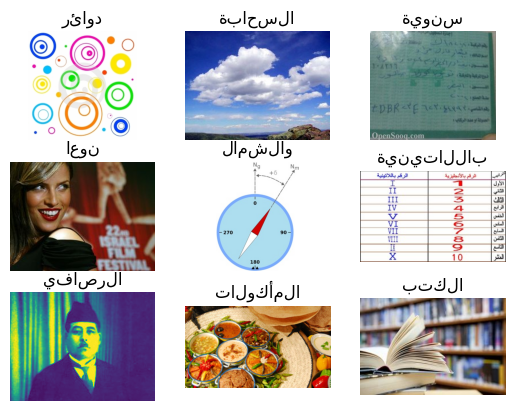

In [59]:
# create a plot of the first image from the first 9 folders
# to ensure the images can be read into memory
for i, p in enumerate(parent_folders[:9]):
    
    # create a 3x3 figure and place the images accordingly
    ax = plt.subplot(3, 3, i + 1)
    
    # open the first image (01.jpg) and output to the subplot
    im = Image.open(f'{folder_path}{p}/01.jpg')
    plt.imshow(im)
    
    # add titles above the images and also print them as text.
    # this partially addresses the problem with Matplotlib not printing 
    # the connected Arabic letters.
    # source: # partial fixing: https://stackoverflow.com/questions/15421746/matplotlib-writing-right-to-left-text-hebrew-arabic-etc
    print(p)
    plt.title(p[::-1])
    plt.axis('off')

From the image grid above, it is clear that the image dataset consists of a mixture of illustrations, photographs and text-like images. The complexity of the input dataset might confuse CNN models.

##### Extract image dimensions (metadata)

The `full_paths.csv` file written out earlier contains an entire list of image files in each directory. This list can be passed to PySpark, where a chunk of images can be read in, the dimensions extracted by the PIL library and the contents added to a PySpark DataFrame.

This technique overcomes the difficulty and memory bottleneck of reading of the entire dataset first and then looping through the images to determine their dimensions, although the initial coding can appear to be slightly more complicated.

In [1]:
# import pyspark modules to instantiate a session
from pyspark.sql.functions import base64, col
from pyspark.sql import SparkSession
from pyspark import SparkContext

# import the PIL Image module to print image content to jupyter cells
from PIL import Image

# import pandas and matplotlib libraries for data wrangling and plotting
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# instantiate a SparkContext object with an app name 'metadata', which logically
# describes the process - i.e. getting the data of image data
sc = SparkContext(appName='metadata')

# also, instantiate a SparkSession object on a local machine
spark = SparkSession.builder.master('local').appName('metadata').getOrCreate()

bash: /home/ubuntu/miniconda3/lib/libtinfo.so.6: no version information available (required by bash)
bash: /home/ubuntu/miniconda3/lib/libtinfo.so.6: no version information available (required by bash)
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/25 18:33:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# set a partition size of 1 less than the number of CPUs available, so that
# background tasks can continue while pyspark is running
partitions = 3

In [7]:
def readchunk(v):
    """
    this is a wrapper function to open each image, 
    and return the width and height values.
    
    v is simply a string containing the file path
    """
    
    # open the image using PIL
    _img = Image.open(v)
    
    # from the 'size' attribute, get the width and height, respectively
    # (width, height and not height, width)
    w, h = _img.size[0], _img.size[1]
    return w, h

In [8]:
# read in the entire list of file paths, and then use the map function 
# to obtain a single list of tuples containing the image dimensions

# split the map function across several partitions (3 in this case)
sc_full_paths = sc.textFile('full_paths.csv', minPartitions=partitions)

# pass each file path to the 'readchunk' wrapper function
# don't use flatMap as it will flatten the resulting list
rdd = sc_full_paths.map(readchunk)

At this stage, the `rdd` object (resilient distributed dataframe) contains only the integer values of image height and widths. From a data management perspective, there is a significant reduction of memory used. For example, a 256x256 image has 65,536 pixels, each of which will have 3 channels representing red, green and blue (RGB) colours. Loading the entire dataset only to obtain their dimensons would have required the use of a high-specification machine and a long read time. If the dataset were to be significantly larger, such as petabytes in genomic usecases, this task would have been impossible.

Once the dimensions are available, a PySpark DataFrame (which is similar to Pandas DataFrame) can be created and used for further downstream applications.

In [13]:
# create a dataframe out of the list
rdd_spark = spark.createDataFrame(rdd)

# rename the columns accordingly
print('before:', rdd_spark.columns) # print out the original column names
rdd_spark = rdd_spark.withColumnRenamed('_1', 'width').withColumnRenamed('_2', 'height')
print('after:', rdd_spark.columns) # print out the renamed columns

before: ['_1', '_2']
after: ['width', 'height']


In [14]:
# convert the PySpark DataFrame to a Pandas DataFrame,
# as the amount of data should be significantly smaller.
rdd_df = rdd_spark.toPandas()
rdd_df.info()

# write out the results to disk for backup
rdd_df.to_parquet('rdd_df_full.pq', index=False)

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937416 entries, 0 to 937415
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   width   937416 non-null  int64
 1   height  937416 non-null  int64
dtypes: int64(2)
memory usage: 14.3 MB


The `info` function of the Pandas DataFrame illustrates how a 20 GiB image dataset can be summarised into a thousand-fold smaller dataset. This dataset can now be used to understand the distribution of image dimensions.

In [206]:
# calculate the frequency of height values
height_counts = rdd_df['height'].value_counts().reset_index()

# rename the columns accordingly
height_counts.rename(columns={'index': 'height', 'height': 'count'}, inplace=True)

# print out the first few rows
height_counts.head(5)

,height,count
0,192,115201
1,144,83766
2,256,73336
3,171,44868
4,170,27959


In [207]:
# do the same for width values
width_counts = rdd_df['width'].value_counts().reset_index()
width_counts.rename(columns={'index': 'width', 'width': 'count'}, inplace=True)
width_counts.head(5)

,width,count
0,256,895366
1,250,5817
2,220,4601
3,200,3928
4,180,2061


In [211]:
print(height_counts.shape[0], width_counts.shape[0])

872 230


At this stage, the image dimensions data have been further reduced into frequency counts, which will allow plotting of bar charts. The `value_counts` function is of a significant benefit as the image dimension data were from 1 million images whereas the value counts are only contain 872 and 230 rows for height and width, respectively.

#### 2.3.12 Graphical exploration of image dimensions

From the `width_counts` table, it appears that a significant proportion of images have a width of 256 pixels. A better insight can be obtained through bar charts.

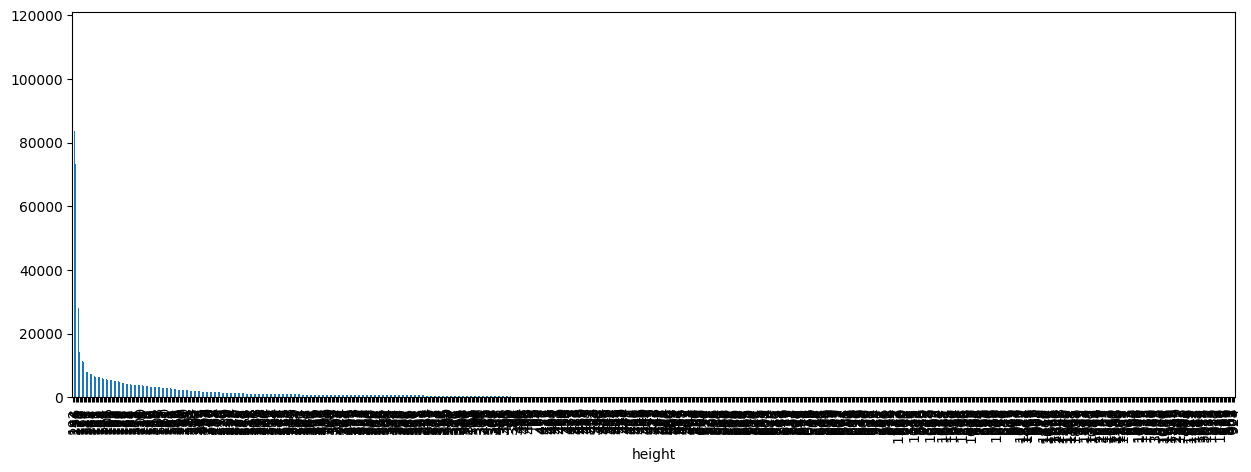

In [212]:
# create a simple bar chart with no formatting for a quick visualisation
height_counts.plot(x='height', y='count', kind='bar', figsize=(15,5), legend=False);

The bar chart for heights clearly illustrates a Pareto-like distribution where the first few height values capture most of the variation in the image sizes. The chart is also squeezed, which is unsurprising given that there are 872 rows.

The visualisation can be improved through better formatting. As many publications charge for colour images and to cater for potentially colourblind readers, the chart will be plotted as black bars.

In [214]:
from matplotlib.ticker import FuncFormatter

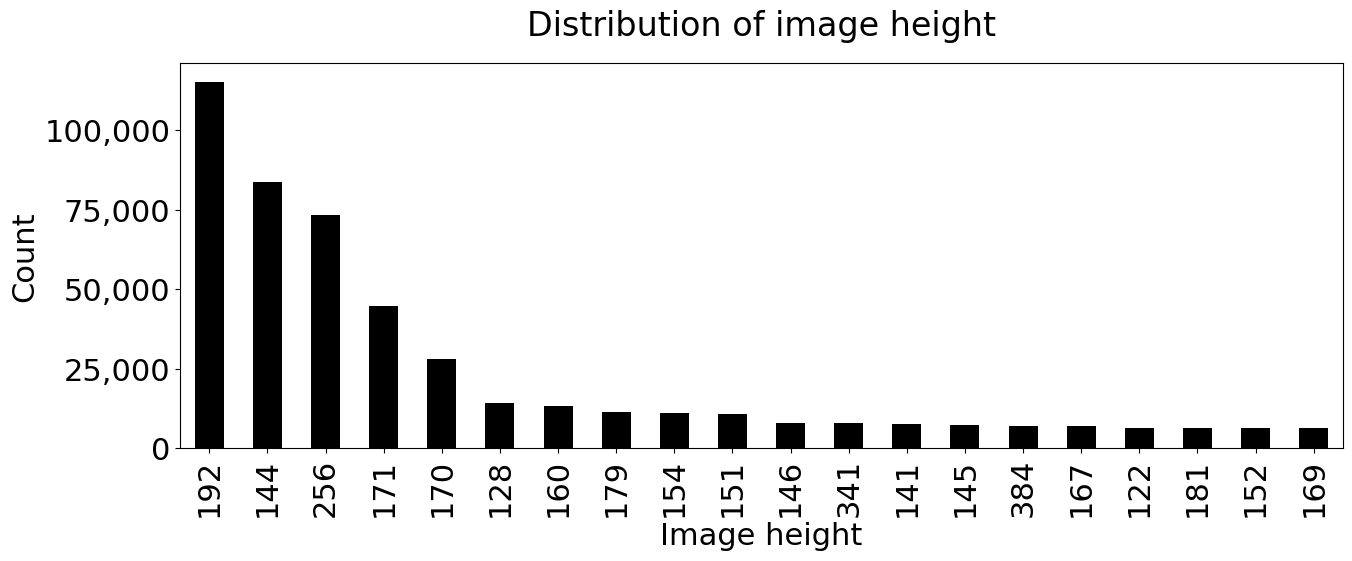

In [216]:
plt.rcParams.update({'font.size': 22})

ax1 = height_counts.iloc[:20].plot(x='height', y='count', kind='bar', figsize=(15,5),
                            legend=False, color='k');
ax1.set_ylabel('Count',fontdict={'fontsize':22})
ax1.set_xlabel('Image height',fontdict={'fontsize':22})
ax1.set_title('Distribution of image height',pad=20, fontdict={'fontsize':24})
ax1.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

In [30]:
# convert the counts to percentage of the entire dataframe length (i.e. number of images)
height_counts['count_pct'] = height_counts['count'] / rdd_df.shape[0] * 100
height_counts.head(5)

,height,count,count_pct
0,192,115201,12.289208
1,144,83766,8.935841
2,256,73336,7.823208
3,171,44868,4.786349
4,170,27959,2.982561


From the bar chart and the count proportions in percentage, the following conclusions can be made:

- Although the largest number of heights are 192 pixels, there are other image heights with significant counts. These height values are not contiguous - for example, the second largest count is 144 pixels followed by 256 pixels.
- The bar chart shows that beyond the top 5 counts, there is a series of various non-contiguous heights that are represented almost equally.

A similar visualisation can also be undertaken for image widths.

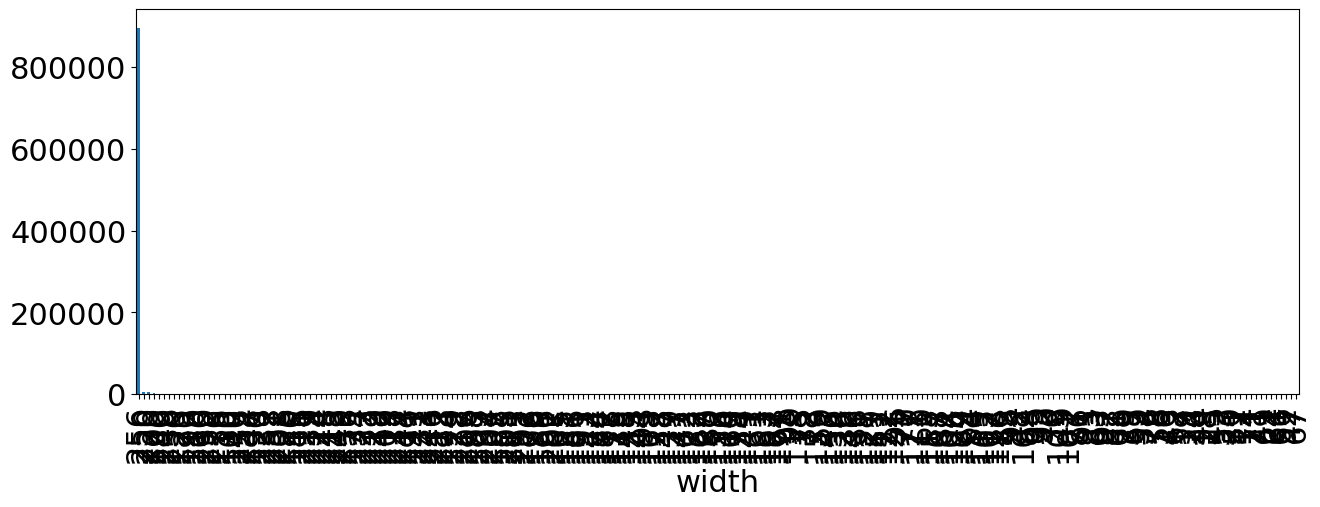

In [217]:
# create a simple bar chart for widths
width_counts.plot(x='width', y='count', kind='bar', figsize=(15,5), legend=False);

The bar chart above is almost totally unreadable. The presence of a single bar at the beginning of the x-axis matches the data from the `width_counts` table, where there are 895,366 images with a width of 256 pixels and the following category of 250 pixels only has 5,817 images. Due to the rather disproportionate representation of the first width, a better bar chart can be created by excluding the counts for 256 pixels and limiting the plotting to only the first 20 width values.

width 	count
0 	256 	895366
1 	250 	5817
2 	220 	4601
3 	200 	3928
4 	180 	2061

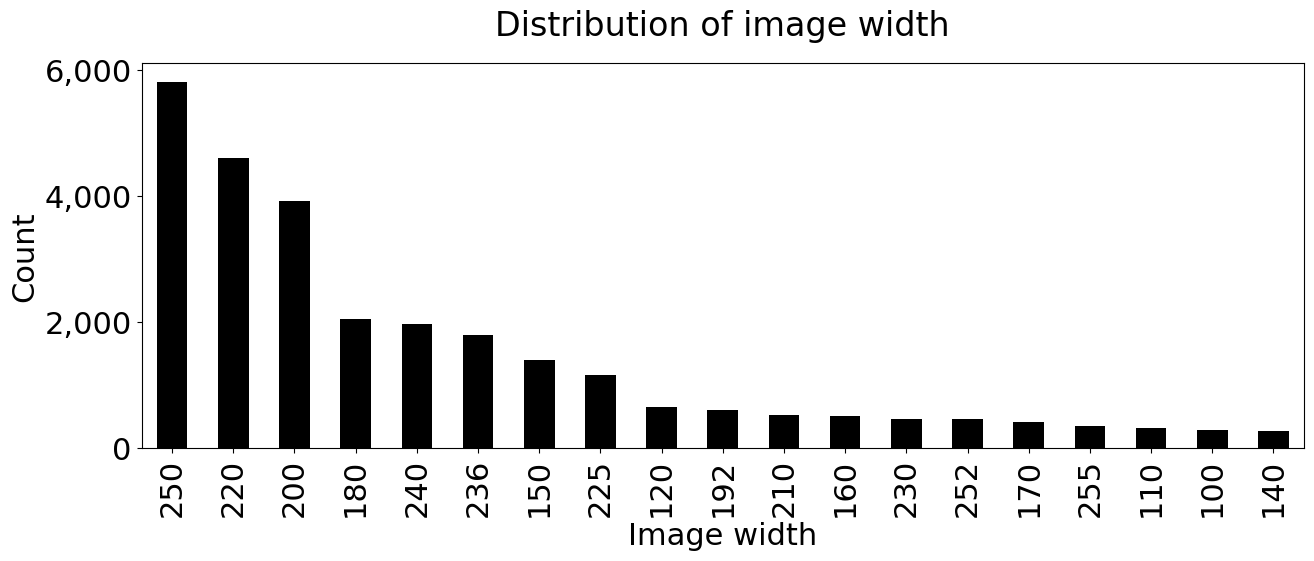

In [218]:
# ignore the first row since its count value is 
# more than 100 times higher than the following one.
# only plot the first 20 width values
plt.rcParams.update({'font.size': 22})

ax1 = width_counts.iloc[1:20].plot(x='width', y='count', kind='bar', figsize=(15,5),
                            legend=False, color='k');
ax1.set_ylabel('Count',fontdict={'fontsize':22})
ax1.set_xlabel('Image width',fontdict={'fontsize':22})
ax1.set_title('Distribution of image width',pad=20, fontdict={'fontsize':24})
ax1.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

In [29]:
# calculate the percentage of images for each width value
width_counts['count_pct'] = width_counts['count'] / rdd_df.shape[0] * 100
width_counts.head(5)

,width,count,count_pct
0,256,895366,95.514265
1,250,5817,0.620536
2,220,4601,0.490817
3,200,3928,0.419024
4,180,2061,0.219860


Seems like the bulk of images have a width of 256 pixels (95 %) whereas the height is more evenly and randomly spread. For example, the highest width count if 256 pixels followed by 250 and 220 whereas for the height, it is 192, 144, 256 and 171 pixels in that order.

## 3. Training using pre-trained CNN models

### 3.1 Training setup 

In this section, convolutional neural network (CNN) will be used to classify images according to their labels.

- Will be using pre-trained models since (i) a lot of research has been done in this area, (ii) these models were trained using large number of images, (iii) save time.
- As was seen at the data processing stage, it is impossible to fit the entire dataset into RAM. Therefore, image generator will be used...
- Move notes from 01_test1 notebook into here.


### 3.2 Preliminary training

Basically to judge which algorithm(s) are the best

### 3.3 Final training

### 3.4. Analysis of training results

Make a few charts...

## 4. Discussion and Future Work

In [1]:
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print('tensorflow version:', tf.version.VERSION)

import pathlib
import shutil

2022-09-28 18:48:45.115333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 18:48:45.878202: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-28 18:48:46.222676: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-28 18:48:48.308341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

tensorflow version: 2.10.0


In [20]:
data_dir = '../full_data/scale-arabic-package/'
#data_dir = pathlib.Path(data_dir)

In [73]:
# make a separate folder to organise train/val/test sets and the respective subfolders
for t in ['train', 'val', 'test']:

    try:
        os.makedirs(f'../full_data_split/{t}')
    except FileExistsError:
        continue

In [150]:
def copyfiles(subset, lbl, tr):
    
    # subset should be one of train, val, test
    # tr is the filename
    # lbl is the folder name under train/val/test folders
    # so the final path will be 'full_data_splt/<subset>/<lbl>/<tr>'
    
    #split_path = f'{data_dir}{lbl}/{tr}'        
    #split_path_subset = f'../full_data_split/{subset}/' + f'{lbl}/{tr}'
    
    split_path = os.path.join(data_dir, lbl, tr)
    split_path_subset = os.path.join('..', 'full_data_split', subset, lbl, tr)

    #print(split_path, split_path_train, sep='::')
    
    try:
        shutil.copy(split_path, split_path_subset, follow_symlinks=False)
    except FileNotFoundError:
        os.makedirs(split_path_subset)
        shutil.copy(split_path, split_path_subset, follow_symlinks=False)

In [153]:
# can't simply take the first 70 images and assign them into train set becuase the image set
# was created by taking the first 100 images from Google Image Search (which already)
# uses some algorithm to sort search results

labels = os.listdir(data_dir)

for l in labels:
    
    if l.endswith('.tsv'):
        continue
    
    fileList = []
    files = os.listdir(data_dir + l)
    for f in files:
        if f.endswith('.jpg'):
            fileList.append(f)
            
    # not all folders have exactly 100 images, so make a list of file names
    # and split randomly accordingly to train/val/test
    setFull = set(fileList)
    setTrain = set(np.random.choice(fileList, size=int(.7*len(setFull)), replace=False))

    # keep only the ones not in setTrain -> split half into val, and another into test
    setValTest = setFull.difference(setTrain)
    setVal = set(np.random.choice(list(setValTest), size=int(.5 * len(setValTest)), 
                                  replace=False ))

    setTest = setValTest.difference(setVal)
    setAll = {'train': setTrain, 'val': setVal, 'test': setTest}
    
    for s in setAll:
        # for each set, iteratively copy the files according to the key (folder name)
        for tr in setAll[s]:
            copyfiles(s, l, tr)

We now have a set of folders, each containing training, validation and test datasets.

Next, we can move on to training.

## 2.2 actual training

- The most important thing when dealing with a large dataset, especially images as they have RGB values, is to avoid loading the entire dataset at one for training. Instead, the images have to be fed into the model in batches.

In [1]:
#from keras.models import Sequential
#from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pandas as pd
import matplotlib.pyplot as plt

import inspect

print('tensorflow version:', tf.version.VERSION)

2022-09-29 19:08:39.698441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 19:08:39.877653: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-29 19:08:40.730698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/miniconda3/lib/
2022-09-29 19:08:40.730815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: 

tensorflow version: 2.10.0


In [2]:
# https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/
# https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

src_path_train = "../full_data_split/train/"
src_path_val = '../full_data_split/val/'
src_path_test = "../full_data_split/test/"

# instantiate generators for each subset. 
# the generators can also be used for image augmentation.
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
batch_size =8 # override for large models
print(batch_size)
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    batch_size=batch_size,
    class_mode='sparse', shuffle=True, seed=42 )
valid_generator = val_datagen.flow_from_directory(
    directory=src_path_val,
    batch_size=batch_size,
    class_mode='sparse', shuffle=True, seed=42)
test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    batch_size=1,
    class_mode=None, shuffle=False, seed=42)

8
Found 651174 images belonging to 9812 classes.
Found 141160 images belonging to 9812 classes.
Found 145082 images belonging to 9812 classes.


In [13]:
class_names = train_generator.labels
num_classes = train_generator.num_classes
print(class_names, num_classes, train_generator.batch_size)

[   0    0    0 ... 9811 9811 9811] 9812 8


In [36]:
def exportHistory(training_history, output):
    # define a helper function to format training history
    # output is the file name
    
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    
    history_df = pd.DataFrame([acc,val_acc,loss, val_loss]).T

    history_df.columns = ['acc', 'val_acc', 'loss', 'val_loss']
    history_df['epoch'] = history_df.index
    history_df.to_csv(output, index=False)
    return history_df

In [38]:
# simple CNN with resize layer followed by rescaling in the second layer
# 

def simpleCNN():
    model = Sequential([
        layers.Resizing(height=img_height, width=img_width, 
                        input_shape=(None, None, 3)
                       ),
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3) ), 
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes) ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  #loss=keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])
        
    return model

model = simpleCNN()

In [39]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_7 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [40]:
# https://medium.com/syntaxerrorpub/what-are-steps-epochs-and-batch-size-in-deep-learning-5c942539a5f8

history = model.fit(train_generator, validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=3
                   )

Epoch 1/3
11125/81396 [===>..........................] - ETA: 16:49 - loss: 9.3528 - accuracy: 8.9888e-05

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


29034/81396 [=========>....................] - ETA: 12:10 - loss: 9.3305 - accuracy: 7.3191e-05

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


76122/81396 [===========================>..] - ETA: 1:13 - loss: 9.2872 - accuracy: 6.2400e-05

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


81396/81396 [==============================] - 1402s 17ms/step - loss: 9.2849 - accuracy: 5.9893e-05 - val_loss: 9.2250 - val_accuracy: 1.0626e-04
Epoch 2/3
81396/81396 [==============================] - 1391s 17ms/step - loss: 9.2437 - accuracy: 6.1428e-05 - val_loss: 9.2223 - val_accuracy: 1.0626e-04
Epoch 3/3
81396/81396 [==============================] - 1380s 17ms/step - loss: 9.2423 - accuracy: 7.2178e-05 - val_loss: 9.2221 - val_accuracy: 1.0626e-04


In [41]:
exportHistory(history, 'res_simpleCNN.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.000060,0.000106,9.284873,9.224996,0
1,0.000061,0.000106,9.243672,9.222335,1
2,0.000072,0.000106,9.242345,9.222108,2


## pre-trained models

In [20]:
# to compare speed:
# https://datascience.stackexchange.com/questions/39177/which-is-the-fastest-image-pretrained-model

# https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4

In [15]:
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(
                        tf.keras.applications, inspect.isfunction)}
model_dictionary

{'ConvNeXtBase': <function keras.applications.convnext.ConvNeXtBase(model_name='convnext_base', include_top=True, include_preprocessing=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
 'ConvNeXtLarge': <function keras.applications.convnext.ConvNeXtLarge(model_name='convnext_large', include_top=True, include_preprocessing=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
 'ConvNeXtSmall': <function keras.applications.convnext.ConvNeXtSmall(model_name='convnext_small', include_top=True, include_preprocessing=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
 'ConvNeXtTiny': <function keras.applications.convnext.ConvNeXtTiny(model_name='convnext_tiny', include_top=True, include_preprocessing=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=N

## MobileNetV2

choose small models for (i) faster training, (ii) justify by saying it is for mobile devices with limited compute power.

In [32]:
mobnetv2 = model_dictionary['MobileNetV2']()# include_top=False, pooling='avg'
mobnetv2.trainable = False # freeze

img_height = mobnetv2.input_shape[1]
img_width = mobnetv2.input_shape[2]
print(img_height, img_width)

224 224


In [33]:
mobnetv2_model = Sequential()
mobnetv2_model.add(layers.Resizing( height=img_height, width=img_width, 
                            input_shape=(None, None, 3)
                                  ))
mobnetv2_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)) )
mobnetv2_model.add(mobnetv2)
mobnetv2_model.add(layers.Dense(num_classes))
mobnetv2_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

mobnetv2_history = mobnetv2_model.fit(train_generator, validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=3
                   )

Epoch 1/3
13732/81396 [====>.........................] - ETA: 20:18 - loss: 9.1840 - accuracy: 0.0024

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


21544/81396 [======>.......................] - ETA: 18:10 - loss: 9.0816 - accuracy: 0.0037

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


79271/81396 [============================>.] - ETA: 36s - loss: 8.7019 - accuracy: 0.0114

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


81396/81396 [==============================] - 1716s 21ms/step - loss: 8.6938 - accuracy: 0.0115 - val_loss: 8.3854 - val_accuracy: 0.0196
Epoch 2/3
81396/81396 [==============================] - 1515s 19ms/step - loss: 8.1154 - accuracy: 0.0269 - val_loss: 8.3798 - val_accuracy: 0.0245
Epoch 3/3
81396/81396 [==============================] - 1550s 19ms/step - loss: 7.9626 - accuracy: 0.0333 - val_loss: 8.4539 - val_accuracy: 0.0265


In [37]:
exportHistory(mobnetv2_history, 'res_mobnetv2.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.011533,0.019595,8.693822,8.385377,0
1,0.026886,0.024532,8.115376,8.379798,1
2,0.033340,0.026488,7.962585,8.453864,2


In [ ]:
# https://keras.io/api/applications/mobilenet/
# https://datascience.stackexchange.com/questions/30859/is-there-any-proven-disadvantage-of-transfer-learning-for-cnns
# try NASNetMobile, MobileNetV3, Xception ...
# https://keras.io/api/applications/ --> table of pre-trained models

# develop a code framework that basically captures the use of pre-trained models (a few
# different architectures), use callbacks to save intermediate training for fault 
# tolerance and then find the best one (i.e. with just 3 epochs). once the best one has
# been determined, full training can be done

# use multiple GPUs (callbacks + fault tolerance)

## NASNetMobile

In [43]:
nasnetmobile = model_dictionary['NASNetMobile']()# include_top=False, pooling='avg'
nasnetmobile.trainable = False # freeze

img_height = nasnetmobile.input_shape[1]
img_width = nasnetmobile.input_shape[2]
print(img_height, img_width)

24227760/24227760 [==============================] - 0s 0us/step
224 224


In [44]:
nasnetmobile_model = Sequential()
nasnetmobile_model.add(layers.Resizing( height=img_height, width=img_width, 
                            input_shape=(None, None, 3)
                                  ))
nasnetmobile_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)) )
nasnetmobile_model.add(nasnetmobile)
nasnetmobile_model.add(layers.Dense(num_classes))
nasnetmobile_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

nasnetmobile_history = nasnetmobile_model.fit(train_generator, 
                                              validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=3 )

Epoch 1/3
 7383/81396 [=>............................] - ETA: 45:38 - loss: 9.2638 - accuracy: 0.0011

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


39432/81396 [=============>................] - ETA: 25:22 - loss: 8.8996 - accuracy: 0.0061

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


77008/81396 [===========================>..] - ETA: 2:39 - loss: 8.7060 - accuracy: 0.0097

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


81396/81396 [==============================] - 3524s 43ms/step - loss: 8.6910 - accuracy: 0.0101 - val_loss: 8.3956 - val_accuracy: 0.0176
Epoch 2/3
81396/81396 [==============================] - 3477s 43ms/step - loss: 8.1688 - accuracy: 0.0204 - val_loss: 8.4059 - val_accuracy: 0.0207
Epoch 3/3
81396/81396 [==============================] - 3468s 43ms/step - loss: 8.0580 - accuracy: 0.0242 - val_loss: 8.4771 - val_accuracy: 0.0212


In [45]:
exportHistory(nasnetmobile_history, 'res_nasnetmobile.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.010094,0.017597,8.690969,8.395569,0
1,0.020440,0.020679,8.168805,8.405867,1
2,0.024243,0.021224,8.057956,8.477056,2


## MobileNetV3Large

In [50]:
mobilenetv3L = model_dictionary['MobileNetV3Large']()# include_top=False, pooling='avg'
mobilenetv3L.trainable = False # freeze

img_height = mobilenetv3L.input_shape[1]
img_width = mobilenetv3L.input_shape[2]
print(img_height, img_width)

22661472/22661472 [==============================] - 0s 0us/step
None None


In [52]:
mobilenetv3L_model = Sequential()
mobilenetv3L_model.add(layers.Resizing( height=225, width=225, 
                            input_shape=(None, None, 3)
                                  ))
mobilenetv3L_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)) )
mobilenetv3L_model.add(mobilenetv3L)
mobilenetv3L_model.add(layers.Dense(num_classes))
mobilenetv3L_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

mobilenetv3L_history = mobilenetv3L_model.fit(train_generator, 
                                              validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=3 )

Epoch 1/3
20646/81396 [======>.......................] - ETA: 14:59 - loss: 9.3920 - accuracy: 7.8709e-05

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


21864/81396 [=======>......................] - ETA: 14:42 - loss: 9.3877 - accuracy: 8.0041e-05

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


56593/81396 [===================>..........] - ETA: 6:06 - loss: 9.3173 - accuracy: 7.7307e-05

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


81396/81396 [==============================] - 1443s 18ms/step - loss: 9.3002 - accuracy: 7.0643e-05 - val_loss: 9.2358 - val_accuracy: 1.0626e-04
Epoch 2/3
81396/81396 [==============================] - 1481s 18ms/step - loss: 9.2557 - accuracy: 1.0136e-04 - val_loss: 9.2344 - val_accuracy: 1.5585e-04
Epoch 3/3
81396/81396 [==============================] - 1481s 18ms/step - loss: 9.2529 - accuracy: 1.0443e-04 - val_loss: 9.2321 - val_accuracy: 2.3378e-04


In [53]:
exportHistory(mobilenetv3L_history, 'res_mobilenetv3L.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.000071,0.000106,9.300216,9.235794,0
1,0.000101,0.000156,9.255728,9.234437,1
2,0.000104,0.000234,9.252872,9.232113,2


## Inception V3

In [54]:
inceptionv3 = model_dictionary['InceptionV3']()# include_top=False, pooling='avg'
inceptionv3.trainable = False # freeze

img_height = inceptionv3.input_shape[1]
img_width = inceptionv3.input_shape[2]
print(img_height, img_width)

96112376/96112376 [==============================] - 1s 0us/step
299 299


In [55]:
inceptionv3_model = Sequential()
inceptionv3_model.add(layers.Resizing( height=img_height, width=img_width, 
                            input_shape=(None, None, 3) ))
inceptionv3_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)) )
inceptionv3_model.add(inceptionv3)
inceptionv3_model.add(layers.Dense(num_classes))
inceptionv3_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

inceptionv3_history = inceptionv3_model.fit(train_generator, 
                                              validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=3 )

Epoch 1/3
 2537/81396 [..............................] - ETA: 29:21 - loss: 9.2612 - accuracy: 5.9125e-04

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


36648/81396 [============>.................] - ETA: 16:14 - loss: 8.9393 - accuracy: 0.0066

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


56893/81396 [===================>..........] - ETA: 8:52 - loss: 8.8095 - accuracy: 0.0093

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


81396/81396 [==============================] - 2111s 26ms/step - loss: 8.7088 - accuracy: 0.0118 - val_loss: 8.4208 - val_accuracy: 0.0198
Epoch 2/3
81396/81396 [==============================] - 2095s 26ms/step - loss: 8.1641 - accuracy: 0.0248 - val_loss: 8.4496 - val_accuracy: 0.0234
Epoch 3/3
81396/81396 [==============================] - 2135s 26ms/step - loss: 8.0420 - accuracy: 0.0295 - val_loss: 8.5398 - val_accuracy: 0.0241


In [56]:
exportHistory(inceptionv3_history, 'res_inceptionv3.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.011830,0.019829,8.708822,8.420783,0
1,0.024769,0.023441,8.164121,8.449586,1
2,0.029479,0.024107,8.042038,8.539799,2


## InceptionResNet V2

In [57]:
inceptionResNet = model_dictionary['InceptionResNetV2']()# include_top=False, pooling='avg'
inceptionResNet.trainable = False # freeze

img_height = inceptionResNet.input_shape[1]
img_width = inceptionResNet.input_shape[2]
print(img_height, img_width)

225209952/225209952 [==============================] - 1s 0us/step
299 299


In [58]:
inceptionResNet_model = Sequential()
inceptionResNet_model.add(layers.Resizing( height=img_height, width=img_width, 
                            input_shape=(None, None, 3) ))
inceptionResNet_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)) )
inceptionResNet_model.add(inceptionResNet)
inceptionResNet_model.add(layers.Dense(num_classes))
inceptionResNet_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

inceptionResNet_history = inceptionResNet_model.fit(train_generator, 
                                              validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=3 )

Epoch 1/3
    4/81396 [..............................] - ETA: 1:17:17 - loss: 9.1919 - accuracy: 0.0000e+00

2022-09-30 20:17:13.469627: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-30 20:17:13.469687: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 8303/81396 [==>...........................] - ETA: 1:03:31 - loss: 9.2426 - accuracy: 0.0017

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


13223/81396 [===>..........................] - ETA: 58:46 - loss: 9.1686 - accuracy: 0.0025

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


25853/81396 [========>.....................] - ETA: 47:23 - loss: 8.9967 - accuracy: 0.0051

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


36064/81396 [============>.................] - ETA: 38:35 - loss: 8.8948 - accuracy: 0.0067

2022-09-30 20:47:55.718290: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-30 20:47:55.718348: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


81396/81396 [==============================] - 4989s 61ms/step - loss: 8.6561 - accuracy: 0.0123 - val_loss: 8.3767 - val_accuracy: 0.0208
Epoch 2/3
81396/81396 [==============================] - 4953s 61ms/step - loss: 8.1208 - accuracy: 0.0242 - val_loss: 8.4562 - val_accuracy: 0.0238
Epoch 3/3
81396/81396 [==============================] - 4961s 61ms/step - loss: 8.0228 - accuracy: 0.0281 - val_loss: 8.5698 - val_accuracy: 0.0250


In [59]:
exportHistory(inceptionResNet_history, 'res_inceptionResNet.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.012326,0.020771,8.656085,8.376688,0
1,0.024209,0.023831,8.120756,8.456215,1
2,0.028067,0.024957,8.022768,8.569838,2


## VGG19

In [60]:
vgg19 = model_dictionary['VGG19']()# include_top=False, pooling='avg'
vgg19.trainable = False # freeze

img_height = vgg19.input_shape[1]
img_width = vgg19.input_shape[2]
print(img_height, img_width)

574710816/574710816 [==============================] - 4s 0us/step
224 224


In [61]:
vgg19_model = Sequential()
vgg19_model.add(layers.Resizing(height=img_height, width=img_width, 
                                input_shape=(None, None, 3)))
vgg19_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)) )
vgg19_model.add(vgg19)
vgg19_model.add(layers.Dense(num_classes))
vgg19_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

vgg19_history = vgg19_model.fit(train_generator, 
                                              validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=3 )

Epoch 1/3
12564/81396 [===>..........................] - ETA: 24:00 - loss: 9.4284 - accuracy: 1.3929e-04

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


15881/81396 [====>.........................] - ETA: 22:49 - loss: 9.4111 - accuracy: 1.3381e-04

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


45754/81396 [===============>..............] - ETA: 12:20 - loss: 9.3013 - accuracy: 2.8413e-04

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


81396/81396 [==============================] - 2031s 25ms/step - loss: 9.2414 - accuracy: 3.9928e-04 - val_loss: 9.1180 - val_accuracy: 0.0011
Epoch 2/3
81396/81396 [==============================] - 2042s 25ms/step - loss: 9.0902 - accuracy: 0.0011 - val_loss: 9.0410 - val_accuracy: 0.0018
Epoch 3/3
81396/81396 [==============================] - 2039s 25ms/step - loss: 9.0174 - accuracy: 0.0018 - val_loss: 8.9869 - val_accuracy: 0.0022


In [62]:
exportHistory(vgg19_history, 'res_vgg19.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.000399,0.001133,9.241376,9.117986,0
1,0.001138,0.001785,9.090199,9.041047,1
2,0.001827,0.002210,9.017396,8.986883,2


## Xception

In [63]:
xception = model_dictionary['Xception']()# include_top=False, pooling='avg'
xception.trainable = False # freeze

img_height = xception.input_shape[1]
img_width = xception.input_shape[2]
print(img_height, img_width)

91884032/91884032 [==============================] - 1s 0us/step
299 299


In [64]:
xception_model = Sequential()
xception_model.add(layers.Resizing( height=img_height, width=img_width, 
                            input_shape=(None, None, 3) ))
xception_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)) )
xception_model.add(xception)
xception_model.add(layers.Dense(num_classes))
xception_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

xception_history = xception_model.fit(train_generator, 
                                      validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=3 )

Epoch 1/3
  902/81396 [..............................] - ETA: 31:48 - loss: 9.2086 - accuracy: 2.7716e-04

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


 1189/81396 [..............................] - ETA: 31:40 - loss: 9.2202 - accuracy: 2.1026e-04

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


37358/81396 [============>.................] - ETA: 17:48 - loss: 8.9128 - accuracy: 0.0067

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


81396/81396 [==============================] - 2354s 29ms/step - loss: 8.6770 - accuracy: 0.0122 - val_loss: 8.3577 - val_accuracy: 0.0209
Epoch 2/3
81396/81396 [==============================] - 2353s 29ms/step - loss: 8.1244 - accuracy: 0.0260 - val_loss: 8.3342 - val_accuracy: 0.0256
Epoch 3/3
81396/81396 [==============================] - 2318s 28ms/step - loss: 7.9907 - accuracy: 0.0313 - val_loss: 8.3967 - val_accuracy: 0.0272


In [65]:
exportHistory(xception_history, 'res_xception.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.012210,0.020856,8.677006,8.357737,0
1,0.025955,0.025638,8.124438,8.334207,1
2,0.031333,0.027168,7.990734,8.396714,2


Very Deep Convolutional Networks for Large-Scale Image Recognition (VGG-16) or VGG-19
ResNet50.
Xception
https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/
https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96
    
- use the last article as a basis to write intro/background into different architectures etc.
- 1500 words for intro, 1500 for materials + results + 1500 discussion --> 4500 total
- another 500-ish for conclusion --> target 5000 words --> maybe 2000 words for intro to cover the depth of deep learning, explain arabic problems with pictures etc.
- maybe touch on 'graphics/inappropriate' pictures --> why image recognition can be controversial/unethical etc.


## initial training analysis

In [67]:
import os

In [70]:
# create a list of result files
res_files = []

for f in os.listdir():
    if f.startswith('res_') & f.endswith('.csv'):
        res_files.append(f)
        
res_files

['res_xception.csv',
 'res_vgg19.csv',
 'res_inceptionResNet.csv',
 'res_inceptionv3.csv',
 'res_mobilenetv3L.csv',
 'res_simpleCNN.csv',
 'res_mobnetv2.csv',
 'res_nasnetmobile.csv']

In [77]:
# create a list of pandas dataframe so one master result dataframe can be obtained
res_files_df = []

for f in res_files:
    df = pd.read_csv(f)
    df['model'] = f.split('res_')[-1].split('.csv')[0]
    res_files_df.append(df)

res_files_df = pd.concat(res_files_df)

In [79]:
# reset all the indices and drop them
res_files_df.reset_index(inplace=True, drop=True)

res_files_df.to_csv('res_combined.csv', index=False)

In [80]:
res_files_df

,acc,val_acc,loss,val_loss,epoch,model
0,0.012210,0.020856,8.677006,8.357737,0,xception
1,0.025955,0.025638,8.124438,8.334207,1,xception
2,0.031333,0.027168,7.990734,8.396714,2,xception
3,0.000399,0.001133,9.241376,9.117986,0,vgg19
4,0.001138,0.001785,9.090199,9.041047,1,vgg19
5,0.001827,0.002210,9.017396,8.986883,2,vgg19
6,0.012326,0.020771,8.656085,8.376688,0,inceptionResNet
7,0.024209,0.023831,8.120756,8.456215,1,inceptionResNet
8,0.028067,0.024957,8.022768,8.569838,2,inceptionResNet
9,0.011830,0.019829,8.708822,8.420783,0,inceptionv3


In [90]:
res_models_initial = res_files_df.groupby('model').first()
res_models_initial.head(2)

,acc,val_acc,loss,val_loss,epoch
model,,,,,
inceptionResNet,0.012326,0.020771,8.656085,8.376688,0
inceptionv3,0.011830,0.019829,8.708822,8.420783,0


In [89]:
res_models_final = res_files_df.groupby('model').last()
res_models_final.head(2)

,acc,val_acc,loss,val_loss,epoch
model,,,,,
inceptionResNet,0.028067,0.024957,8.022768,8.569838,2
inceptionv3,0.029479,0.024107,8.042038,8.539799,2


In [91]:
# append marker strings to the initial and final training columns so the dataframes can
# be merged later
initial_cols = []
final_cols = []

for i in res_models_initial.columns:
    initial_cols.append(i + '_initial')
res_models_initial.columns = initial_cols

for i in res_models_final.columns:
    final_cols.append(i+ '_final')
res_models_final.columns = final_cols

In [94]:
res_models_initial.head(2)

,acc_initial,val_acc_initial,loss_initial,val_loss_initial,epoch_initial
model,,,,,
inceptionResNet,0.012326,0.020771,8.656085,8.376688,0
inceptionv3,0.011830,0.019829,8.708822,8.420783,0


In [95]:
res_models_final.head(2)

,acc_final,val_acc_final,loss_final,val_loss_final,epoch_final
model,,,,,
inceptionResNet,0.028067,0.024957,8.022768,8.569838,2
inceptionv3,0.029479,0.024107,8.042038,8.539799,2


In [97]:
res_models = res_models_initial.merge(res_models_final, 
                                      left_index=True, right_index=True)

In [101]:
# from this dataframe, calculate the difference between the initial and final
# validation accuracy and loss

res_models['val_acc_diff'] = res_models['val_acc_final'] - res_models['val_acc_initial']
res_models['val_loss_diff'] = res_models['val_loss_final'] - res_models['val_loss_initial']

res_models['val_acc_diff_pct'] = (res_models['val_acc_diff']/res_models['val_acc_initial'] 
                                  * 100)
res_models['val_loss_diff_pct'] = (res_models['val_loss_diff']/res_models['val_loss_initial'] 
                                   * 100)

In [112]:
res_models[['val_acc_initial', 'val_loss_initial', 'val_acc_final', 'val_loss_final']] #.head(2)

,val_acc_initial,val_loss_initial,val_acc_final,val_loss_final
model,,,,
inceptionResNet,0.020771,8.376688,0.024957,8.569838
inceptionv3,0.019829,8.420783,0.024107,8.539799
mobilenetv3L,0.000106,9.235794,0.000234,9.232113
mobnetv2,0.019595,8.385377,0.026488,8.453864
nasnetmobile,0.017597,8.395569,0.021224,8.477056
simpleCNN,0.000106,9.224996,0.000106,9.222108
vgg19,0.001133,9.117986,0.002210,8.986883
xception,0.020856,8.357737,0.027168,8.396714


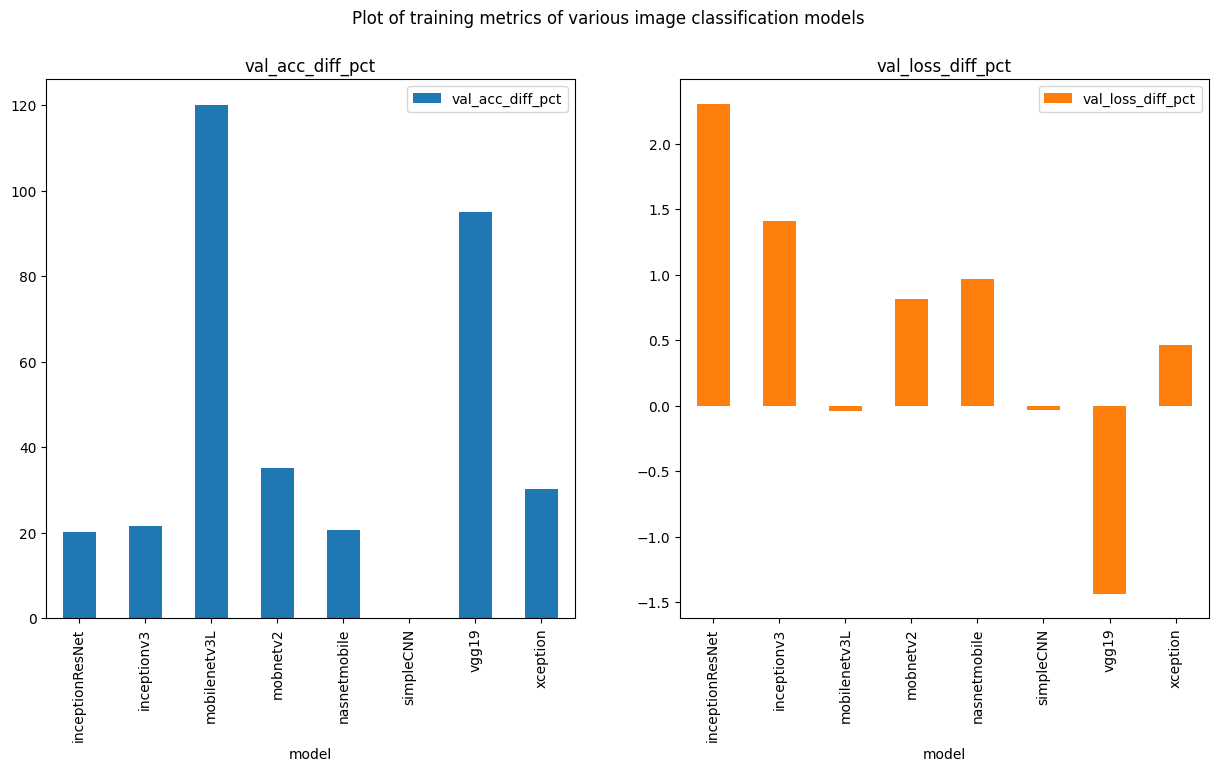

In [110]:
# from the resulting dataframe, the most promising model(s) can be identified

res_models.reset_index().plot(x='model', y= ['val_acc_diff_pct', 'val_loss_diff_pct'], 
              kind='bar', subplots=[('val_acc_diff_pct', ), ('val_loss_diff_pct', )],
             layout=(1,2), figsize=(15,7),
             title='Plot of training metrics of various image classification models');

From the charts above, the MobileNetV3 Large and VGG19 had the largest percentage increase in their validation accuracy. In terms of validation loss improvement, only VGG19 showed a decrease. Given these metrics, these two models will be trained for a higher number of epochs.

## Full training - MobileNetV3 Large

In [147]:
# full training for mobilenetv3L
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Large

mobilenetv3L_base = model_dictionary['MobileNetV3Large'](
                        include_top=False, minimalistic=True, include_preprocessing=True)

mobilenetv3L_base.trainable = False
mobilenetv3L_base.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_30 (Rescaling)       (None, None, None,   0           ['input_27[0][0]']               
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling_30[0][0]']           
                                16)                                                

                                                                                                  
 expanded_conv_2/project (Conv2  (None, None, None,   1728       ['re_lu_364[0][0]']              
 D)                             24)                                                               
                                                                                                  
 expanded_conv_2/project/BatchN  (None, None, None,   96         ['expanded_conv_2/project[0][0]']
 orm (BatchNormalization)       24)                                                               
                                                                                                  
 expanded_conv_2/Add (Add)      (None, None, None,   0           ['expanded_conv_1/project/BatchNo
                                24)                              rm[0][0]',                       
                                                                  'expanded_conv_2/project/BatchNo
          

 re_lu_370 (ReLU)               (None, None, None,   0           ['expanded_conv_5/depthwise/Batch
                                120)                             Norm[0][0]']                     
                                                                                                  
 expanded_conv_5/project (Conv2  (None, None, None,   4800       ['re_lu_370[0][0]']              
 D)                             40)                                                               
                                                                                                  
 expanded_conv_5/project/BatchN  (None, None, None,   160        ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)       40)                                                               
                                                                                                  
 expanded_conv_5/Add (Add)      (None, None, None,   0           ['expanded_conv_4/Add[0][0]',    
          

                                                                                                  
 re_lu_376 (ReLU)               (None, None, None,   0           ['expanded_conv_8/depthwise/Batch
                                184)                             Norm[0][0]']                     
                                                                                                  
 expanded_conv_8/project (Conv2  (None, None, None,   14720      ['re_lu_376[0][0]']              
 D)                             80)                                                               
                                                                                                  
 expanded_conv_8/project/BatchN  (None, None, None,   320        ['expanded_conv_8/project[0][0]']
 orm (BatchNormalization)       80)                                                               
                                                                                                  
 expanded_

                                                                                                  
 expanded_conv_11/project (Conv  (None, None, None,   75264      ['re_lu_382[0][0]']              
 2D)                            112)                                                              
                                                                                                  
 expanded_conv_11/project/Batch  (None, None, None,   448        ['expanded_conv_11/project[0][0]'
 Norm (BatchNormalization)      112)                             ]                                
                                                                                                  
 expanded_conv_11/Add (Add)     (None, None, None,   0           ['expanded_conv_10/project/BatchN
                                112)                             orm[0][0]',                      
                                                                  'expanded_conv_11/project/BatchN
          

 re_lu_388 (ReLU)               (None, None, None,   0           ['expanded_conv_14/depthwise/Batc
                                960)                             hNorm[0][0]']                    
                                                                                                  
 expanded_conv_14/project (Conv  (None, None, None,   153600     ['re_lu_388[0][0]']              
 2D)                            160)                                                              
                                                                                                  
 expanded_conv_14/project/Batch  (None, None, None,   640        ['expanded_conv_14/project[0][0]'
 Norm (BatchNormalization)      160)                             ]                                
                                                                                                  
 expanded_conv_14/Add (Add)     (None, None, None,   0           ['expanded_conv_13/Add[0][0]',   
          

In [148]:
mobilenetv3L_full_model = Sequential()
mobilenetv3L_full_model.add(layers.Resizing( height=224, width=224, 
                            input_shape=(None, None, 3)
                                  ))
#mobilenetv3L_full_model.add(layers.Rescaling(1./255, 
#                                            input_shape=(224, 224, 3)
#                                            ) )
mobilenetv3L_full_model.add(mobilenetv3L_base)
mobilenetv3L_full_model.add(layers.GlobalAveragePooling2D())
mobilenetv3L_full_model.add(layers.Dense(num_classes))
mobilenetv3L_full_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

mobilenetv3L_full_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_31 (Resizing)      (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, None, None, 960)  1437608   
 l)                                                              
                                                                 
 global_average_pooling2d_14  (None, 960)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_31 (Dense)            (None, 9812)              9429332   
                                                                 
Total params: 10,866,940
Trainable params: 9,429,332
Non-trainable params: 1,437,608
_________________________________________________________________


In [153]:
# early stopping allows training to stop if a metric (in this case, validation accuracy)
# has stopped increasing for a certain number of epochs (here, it will be 3).
# https://keras.io/api/callbacks/early_stopping/
# in max mode, training will stop when the quantity monitored has stopped increasing
callbacks = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, mode='max')]

In [149]:
mobilenetv3L_full_history = mobilenetv3L_full_model.fit(train_generator, 
                                              validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=10, callbacks=callbacks )

Epoch 1/10
12770/81396 [===>..........................] - ETA: 15:10 - loss: 13.2368 - accuracy: 0.0157

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


23280/81396 [=======>......................] - ETA: 12:51 - loss: 12.8715 - accuracy: 0.0214

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


80515/81396 [============================>.] - ETA: 11s - loss: 12.5008 - accuracy: 0.0333

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


81396/81396 [==============================] - 1285s 16ms/step - loss: 12.5015 - accuracy: 0.0334 - val_loss: 12.4345 - val_accuracy: 0.0425
Epoch 2/10
81396/81396 [==============================] - 1256s 15ms/step - loss: 10.0872 - accuracy: 0.0883 - val_loss: 13.7521 - val_accuracy: 0.0432
Epoch 3/10
81396/81396 [==============================] - 1259s 15ms/step - loss: 9.3962 - accuracy: 0.1184 - val_loss: 14.9511 - val_accuracy: 0.0423
Epoch 4/10
81396/81396 [==============================] - 1332s 16ms/step - loss: 9.0365 - accuracy: 0.1401 - val_loss: 16.0096 - val_accuracy: 0.0407
Epoch 5/10
81396/81396 [==============================] - 1290s 16ms/step - loss: 8.8245 - accuracy: 0.1561 - val_loss: 17.0174 - val_accuracy: 0.0392
Epoch 6/10
81396/81396 [==============================] - 1319s 16ms/step - loss: 8.7096 - accuracy: 0.1690 - val_loss: 17.9670 - val_accuracy: 0.0382
Epoch 7/10
81396/81396 [==============================] - 1278s 16ms/step - loss: 8.6407 - accuracy: 0.

In [150]:
exportHistory(mobilenetv3L_full_history, 'res_full_mobilenetv3L.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.033385,0.042547,12.501539,12.434469,0
1,0.088315,0.043220,10.087151,13.752145,1
2,0.118351,0.042321,9.396201,14.951097,2
3,0.140101,0.040748,9.036533,16.009640,3
4,0.156135,0.039161,8.824525,17.017357,4
5,0.168991,0.038212,8.709633,17.967001,5
6,0.179289,0.036583,8.640743,18.876400,6
7,0.188390,0.036455,8.607593,19.704659,7
8,0.195752,0.036441,8.599066,20.605850,8
9,0.201927,0.035067,8.611310,21.447224,9


In [151]:
# training from scratch --> maybe it is just not good enough when there are 9000 classes
# cf. ImageNet

mobilenetv3L_full_model.trainable = True
mobilenetv3L_full_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_31 (Resizing)      (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, None, None, 960)  1437608   
 l)                                                              
                                                                 
 global_average_pooling2d_14  (None, 960)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_31 (Dense)            (None, 9812)              9429332   
                                                                 
Total params: 10,866,940
Trainable params: 10,842,540
Non-trainable params: 24,400
_________________________________________________________________


In [154]:
mobilenetv3L_fullT_history = mobilenetv3L_full_model.fit(train_generator, 
                                              validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=10, callbacks=callbacks )

Epoch 1/10
 8574/81396 [==>...........................] - ETA: 16:24 - loss: 7.2701 - accuracy: 0.2609

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


16947/81396 [=====>........................] - ETA: 14:24 - loss: 7.4987 - accuracy: 0.2515

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


38149/81396 [=============>................] - ETA: 9:29 - loss: 7.9584 - accuracy: 0.2325

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


81396/81396 [==============================] - 1251s 15ms/step - loss: 8.6405 - accuracy: 0.2074 - val_loss: 22.2553 - val_accuracy: 0.0349
Epoch 2/10
81396/81396 [==============================] - 1304s 16ms/step - loss: 8.6802 - accuracy: 0.2127 - val_loss: 23.0531 - val_accuracy: 0.0343
Epoch 3/10
81396/81396 [==============================] - 1243s 15ms/step - loss: 8.7264 - accuracy: 0.2166 - val_loss: 23.8752 - val_accuracy: 0.0338


In [155]:
exportHistory(mobilenetv3L_fullT_history, 'res_full_mobilenetv3L_unfrozen.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.207448,0.034904,8.640525,22.255341,0
1,0.212709,0.034337,8.680244,23.053074,1
2,0.216604,0.033763,8.726422,23.875225,2


In [160]:
# https://www.tensorflow.org/guide/keras/save_and_serialize
# There are two formats you can use to save an entire model to disk: 
# the TensorFlow SavedModel format, and
# the older Keras H5 format. The recommended format is SavedModel
mobilenetv3L_full_model.save('final_model')

INFO:tensorflow:Assets written to: final_model/assets


INFO:tensorflow:Assets written to: final_model/assets


## Full training - VGG19

In [157]:
vgg19_base = model_dictionary['VGG19'](include_top=False)
vgg19_base.trainable = False
vgg19_base.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [163]:
# add pre-processing layers

vgg19_full_model = Sequential()
vgg19_full_model.add(layers.Resizing( height=224, width=224, 
                            input_shape=(None, None, 3) ))
vgg19_full_model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3) ), )

vgg19_full_model.add(vgg19_base)
vgg19_full_model.add(layers.GlobalAveragePooling2D())
vgg19_full_model.add(layers.Dense(num_classes))
vgg19_full_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

vgg19_full_model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_34 (Resizing)      (None, 224, 224, 3)       0         
                                                                 
 rescaling_33 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d_16  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_34 (Dense)            (None, 9812)              5033556   
                                                                 
Total params: 25,057,940
Trainable params: 5,033,556
Non-trainable params: 20,024,384
_________________________________

In [164]:
vgg19_full_history = vgg19_full_model.fit(train_generator, 
                                              validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=10, callbacks=callbacks )

Epoch 1/10
20960/81396 [======>.......................] - ETA: 20:30 - loss: 9.5511 - accuracy: 0.0049

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


29898/81396 [==========>...................] - ETA: 17:28 - loss: 9.4070 - accuracy: 0.0065

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


59279/81396 [====================>.........] - ETA: 7:31 - loss: 9.2125 - accuracy: 0.0105

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


81396/81396 [==============================] - 2006s 25ms/step - loss: 9.1588 - accuracy: 0.0126 - val_loss: 8.9952 - val_accuracy: 0.0186
Epoch 2/10
81396/81396 [==============================] - 1991s 24ms/step - loss: 8.4877 - accuracy: 0.0300 - val_loss: 9.3019 - val_accuracy: 0.0215
Epoch 3/10
81396/81396 [==============================] - 1982s 24ms/step - loss: 8.3576 - accuracy: 0.0390 - val_loss: 9.6350 - val_accuracy: 0.0229
Epoch 4/10
81396/81396 [==============================] - 1982s 24ms/step - loss: 8.3324 - accuracy: 0.0446 - val_loss: 9.9845 - val_accuracy: 0.0227
Epoch 5/10
81396/81396 [==============================] - 1986s 24ms/step - loss: 8.3593 - accuracy: 0.0490 - val_loss: 10.3028 - val_accuracy: 0.0229
Epoch 6/10
81396/81396 [==============================] - 1966s 24ms/step - loss: 8.4135 - accuracy: 0.0526 - val_loss: 10.6416 - val_accuracy: 0.0220
Epoch 7/10
81396/81396 [==============================] - 2048s 25ms/step - loss: 8.4853 - accuracy: 0.0556 -

In [165]:
exportHistory(vgg19_full_history, 'res_full_vgg19.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.012551,0.018617,9.158765,8.995223,0
1,0.029951,0.021451,8.487725,9.301925,1
2,0.038970,0.022861,8.357645,9.635000,2
3,0.044637,0.022691,8.332407,9.984464,3
4,0.049026,0.022917,8.359282,10.302807,4
5,0.052636,0.022018,8.413533,10.641634,5
6,0.055594,0.021911,8.485282,10.941874,6


In [166]:
vgg19_full_model.save('final_model_vgg19')

INFO:tensorflow:Assets written to: final_model_vgg19/assets


INFO:tensorflow:Assets written to: final_model_vgg19/assets


In [187]:
vgg19_full_model.trainable = True
vgg19_full_model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_34 (Resizing)      (None, 224, 224, 3)       0         
                                                                 
 rescaling_33 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d_16  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_34 (Dense)            (None, 9812)              5033556   
                                                                 
Total params: 25,057,940
Trainable params: 25,057,940
Non-trainable params: 0
_________________________________________

In [188]:
vgg19_fullT_history = vgg19_full_model.fit(train_generator, 
                                              validation_data=valid_generator,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_steps = valid_generator.n // valid_generator.batch_size,
                    epochs=10, callbacks=callbacks )

Epoch 1/10
 4972/81396 [>.............................] - ETA: 26:13 - loss: 8.1861 - accuracy: 0.0659

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


32172/81396 [==========>...................] - ETA: 16:52 - loss: 8.3524 - accuracy: 0.0620

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


70650/81396 [=========================>....] - ETA: 3:40 - loss: 8.5233 - accuracy: 0.0585

/home/ubuntu/miniconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


81396/81396 [==============================] - 2025s 25ms/step - loss: 8.5646 - accuracy: 0.0577 - val_loss: 11.2518 - val_accuracy: 0.0211
Epoch 2/10
81396/81396 [==============================] - 2022s 25ms/step - loss: 8.6513 - accuracy: 0.0603 - val_loss: 11.5463 - val_accuracy: 0.0215
Epoch 3/10
81396/81396 [==============================] - 2026s 25ms/step - loss: 8.7456 - accuracy: 0.0616 - val_loss: 11.8142 - val_accuracy: 0.0214
Epoch 4/10
81396/81396 [==============================] - 2015s 25ms/step - loss: 8.8387 - accuracy: 0.0630 - val_loss: 12.0746 - val_accuracy: 0.0207


In [189]:
exportHistory(vgg19_fullT_history, 'res_full_vgg19_unfrozen.csv')

,acc,val_acc,loss,val_loss,epoch
0,0.057712,0.021132,8.564628,11.251757,0
1,0.060326,0.021536,8.651285,11.546313,1
2,0.061620,0.021366,8.745564,11.814179,2
3,0.062964,0.020693,8.838715,12.074568,3


In [190]:
vgg19_full_model.save('final_modelT_vgg19')

INFO:tensorflow:Assets written to: final_modelT_vgg19/assets


INFO:tensorflow:Assets written to: final_modelT_vgg19/assets


## analysis of full training

In [195]:
res_full_files = []
res_full_files_df = []
for f in os.listdir():
    if f.startswith('res_full') & f.endswith('csv'):
        res_full_files.append(f)

for f in res_full_files:
    df = pd.read_csv(f)
    df['model'] = f.split('res_full_')[-1].split('.csv')[0]
    res_full_files_df.append(df)
    
res_full_files_df = pd.concat(res_full_files_df)
res_full_files_df.to_csv('res_full_combined.csv', index=False)

In [196]:
res_full_files_df.head(4)

,acc,val_acc,loss,val_loss,epoch,model
0,0.207448,0.034904,8.640525,22.255341,0,mobilenetv3L_unfrozen
1,0.212709,0.034337,8.680244,23.053074,1,mobilenetv3L_unfrozen
2,0.216604,0.033763,8.726422,23.875225,2,mobilenetv3L_unfrozen
0,0.012551,0.018617,9.158765,8.995223,0,vgg19


In [197]:
#### FOR FULL RES ~~~

res_full_models_initial = res_full_files_df.groupby('model').first()
res_full_models_initial.head(2)

,acc,val_acc,loss,val_loss,epoch
model,,,,,
mobilenetv3L,0.033385,0.042547,12.501539,12.434469,0
mobilenetv3L_unfrozen,0.207448,0.034904,8.640525,22.255341,0


In [199]:
res_full_models_final = res_full_files_df.groupby('model').last()
res_full_models_final.head(2)

,acc,val_acc,loss,val_loss,epoch
model,,,,,
mobilenetv3L,0.201927,0.035067,8.611310,21.447224,9
mobilenetv3L_unfrozen,0.216604,0.033763,8.726422,23.875225,2


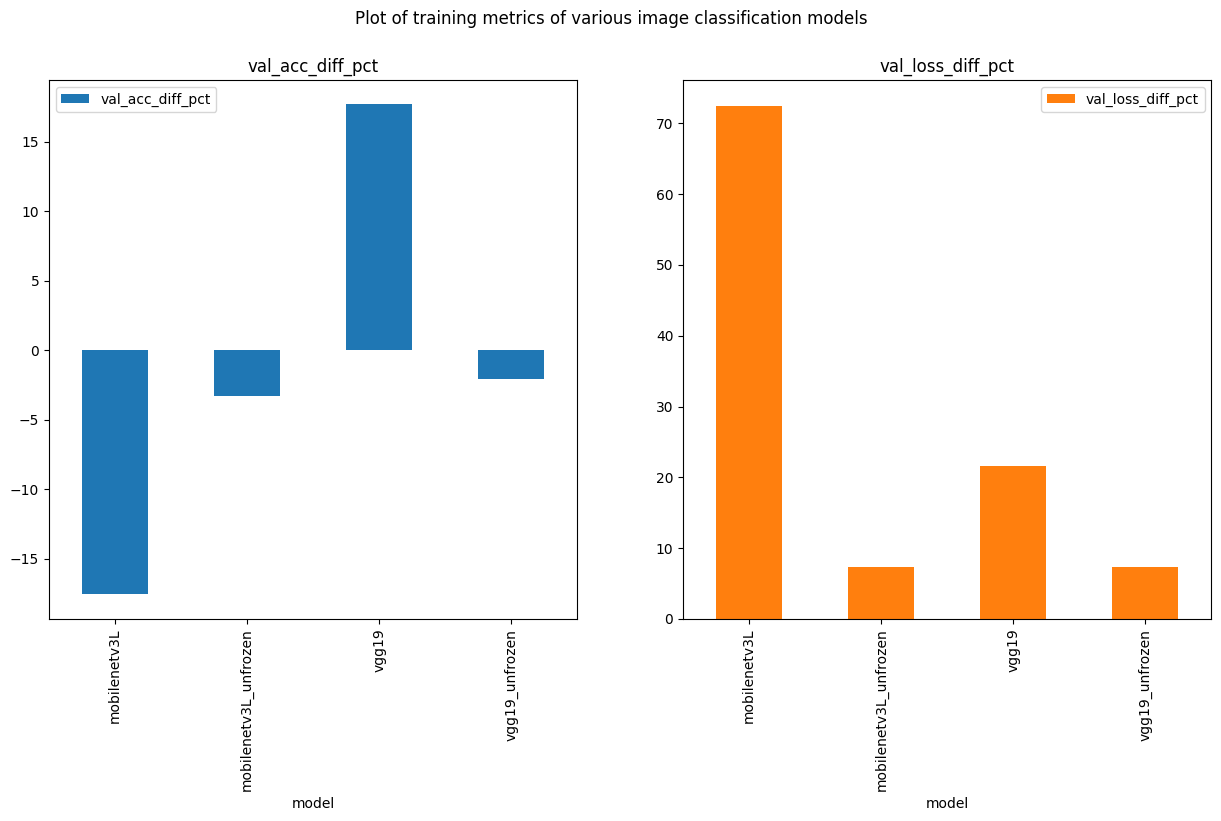

In [200]:
# append marker strings to the initial and final training columns so the dataframes can
# be merged later
initial_cols = []
final_cols = []

for i in res_full_models_initial.columns:
    initial_cols.append(i + '_initial')
res_full_models_initial.columns = initial_cols

for i in res_full_models_final.columns:
    final_cols.append(i+ '_final')
res_full_models_final.columns = final_cols

res_full_models = res_full_models_initial.merge(res_full_models_final, 
                                      left_index=True, right_index=True)

# from this dataframe, calculate the difference between the initial and final
# validation accuracy and loss

res_full_models['val_acc_diff'] = (res_full_models['val_acc_final'] - 
                                   res_full_models['val_acc_initial'])
res_full_models['val_loss_diff'] = (res_full_models['val_loss_final'] - 
                                   res_full_models['val_loss_initial'])

res_full_models['val_acc_diff_pct'] = (res_full_models['val_acc_diff']/
                                       res_full_models['val_acc_initial'] * 100)
res_full_models['val_loss_diff_pct'] = (res_full_models['val_loss_diff']/
                                        res_full_models['val_loss_initial'] * 100)

# from the resulting dataframe, the most promising model(s) can be identified

res_full_models.reset_index().plot(x='model', y= ['val_acc_diff_pct', 'val_loss_diff_pct'], 
              kind='bar', subplots=[('val_acc_diff_pct', ), ('val_loss_diff_pct', )],
             layout=(1,2), figsize=(15,7),
             title='Plot of training metrics of various image classification models');